In [1]:
import mdtraj as md
import pandas as pd
import numpy as np
import plotly.express as px
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
cd desktop\internship\aryan_internship

C:\Users\Aryan\desktop\internship\aryan_internship


In [68]:
#Phase-1 Basic tasks
new_ALA_wat=md.load('ALA_wat_trial.pdb') #Loading the topology file
polar_groups=['O','N','S','F']   #The polar groups present in this molecule

polar_idx=[atom.index for atom in new_ALA_wat.top.atoms if(atom.element.symbol in polar_groups and atom.residue.name!="HOH")] #indices of the polar group
print(polar_idx)

combs=[[idx1,idx2] for idx1 in polar_idx for idx2 in polar_idx ]

combs=np.array(combs)

for idx in polar_idx:
    print(str(new_ALA_wat.top.atom(idx)))


[0, 11, 12, 30, 31, 40, 41]
ALA1-N
ALA1-O
LEU2-N
LEU2-O
ALA3-N
ALA3-O
ALA3-OXT


In [12]:
group_names={'ALA1-N': 'NH-1(ALA1-N)',
 'ALA1-O': 'CO-1(ALA1-O)',
 'LEU2-N': 'NH-2(LEU2-N)',
 'LEU2-O': 'CO-2(LEU2-O)',
 'ALA3-N': 'NH-3(ALA3-N)',
 'ALA3-O': 'CO-3(ALA3-O)',
 'ALA3-OXT': 'CO-4(ALA3-OXT)'}

In [13]:
#Phase-2  
#Average number of bonds formed by each group per frame
#The number of frames in which a bond is formed for each polar group
#The frame wise H-BOND formation binary tracking for each polar group
#The frame wise H-BOND number tracking for each polar group 
#Distribution of H-BOND distances and angles for each polar group 

polar_counts=[0 for idx in polar_idx]  
binary_polar_counts=[0 for idx in polar_idx]
binary_group_track=[[] for idx in polar_idx]
group_track=[[] for idx in polar_idx]
Distances=[[] for idx in polar_idx]
Angles =[[] for idx in polar_idx ]


for frame in md.iterload('ALA_wat_traj.dcd',top='ALA_wat_trial.pdb',chunk=1):
    
    frame_H_BONDS=(md.baker_hubbard(frame,exclude_water=False,distance_cutoff=0.35,angle_cutoff=135))
    
    for bond in frame_H_BONDS:
        for i,idx in enumerate(polar_idx):
            
            if(idx in bond):
                Distances[i].append(md.compute_distances(frame,[[bond[1],bond[2]]]))
                Angles[i].append(md.compute_angles(frame,[bond]))
                
                
                
    frame_H_BONDS= frame_H_BONDS.flatten()
    
    for i,idx in enumerate(polar_idx):
        num=np.count_nonzero(frame_H_BONDS==idx)
        polar_counts[i]=polar_counts[i]+num
        binary_polar_counts[i]=binary_polar_counts[i]+int(bool(num))
        group_track[i].append(num)
        binary_group_track[i].append(int(bool(num)))

        
            
        
            
    

(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ]),
 <a list of 9 Text major ticklabel objects>)

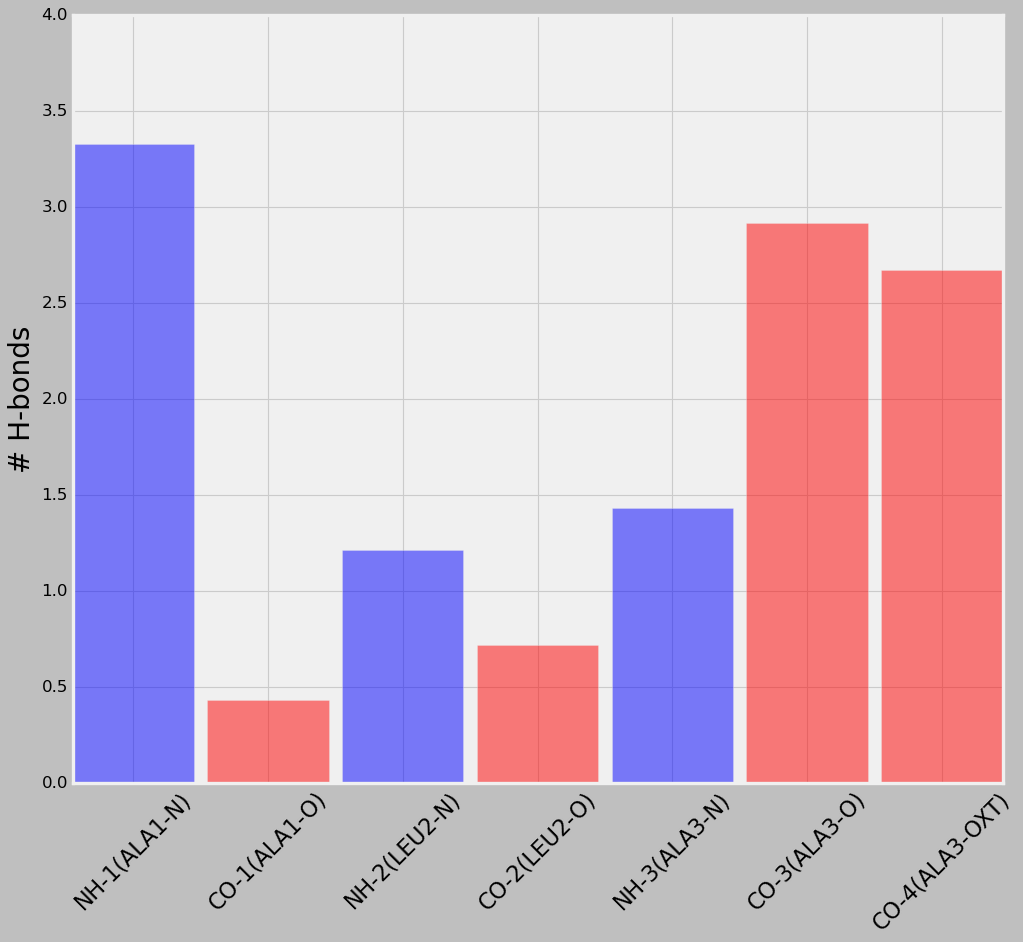

In [268]:
style=dict(size=25,color='black')
polar_counts=np.array(polar_counts)
x_axis=[group_names[str(new_ALA_wat.top.atom(idx))] for idx in polar_idx]
plt.figure(figsize=(15,12))
plt.style.use('fivethirtyeight')
plt.bar(x_axis,polar_counts/102441,width=0.9,color=['blue','red','blue','red','blue','red','red'],alpha=0.5)

plt.ylabel('# H-bonds',**style)
plt.xticks(rotation=45,fontsize=20)
plt.ylim(0,4)
plt.yticks(fontsize=15)



(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 <a list of 7 Text major ticklabel objects>)

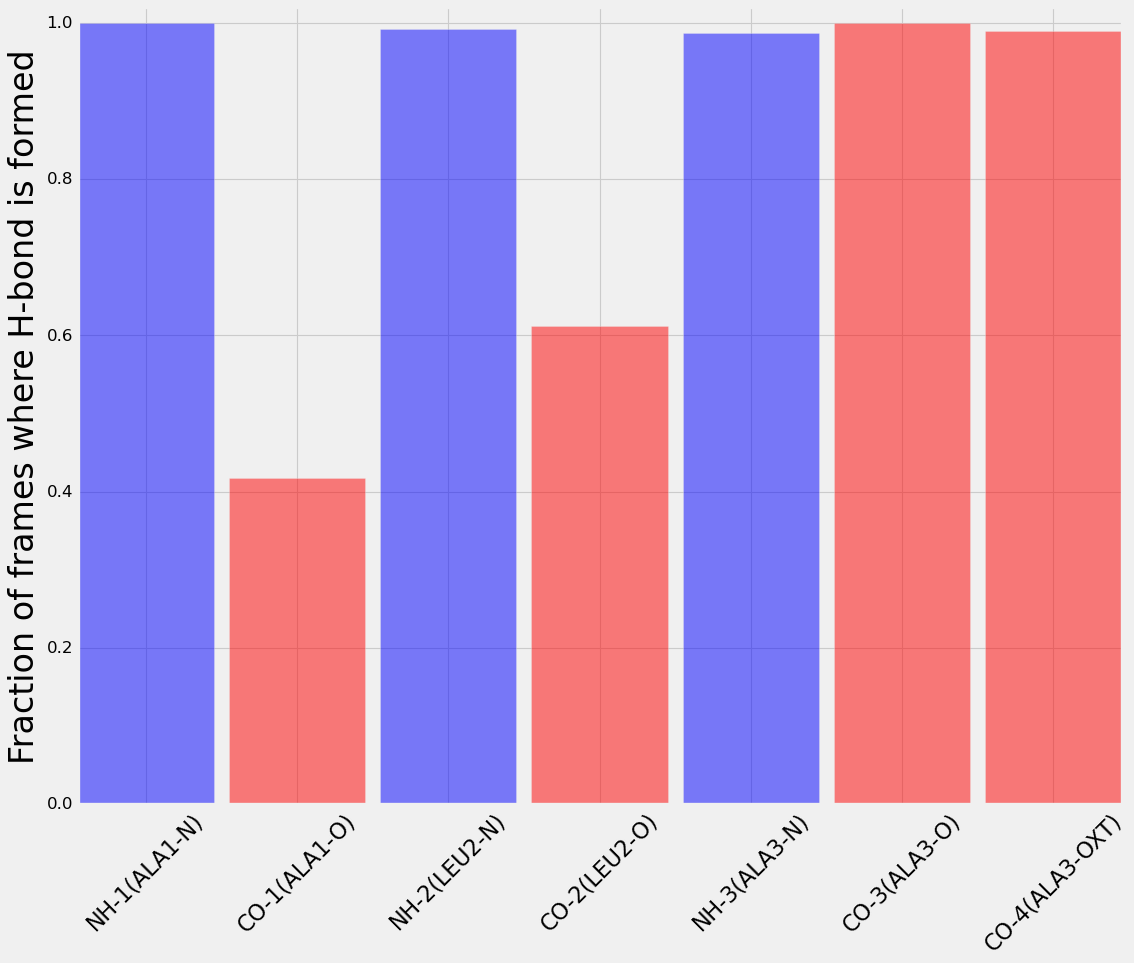

In [266]:
plt.figure(figsize=(15,12))
binary_polar_counts=np.array(binary_polar_counts)

plt.bar(x_axis,binary_polar_counts/102441,width=0.9,color=['blue','red','blue','red','blue','red','red'],alpha=0.5)

plt.ylabel('Fraction of frames where H-bond is formed',**style)
plt.xticks(rotation=45,fontsize=20)
plt.ylim(0,1.02)
plt.yticks(fontsize=15)

In [118]:
for i,distance in enumerate(Distances):
    Distances[i]=np.array(distance).flatten()

In [119]:
for i,angle in enumerate(Angles):
    Angles[i]=np.array(angle).flatten()

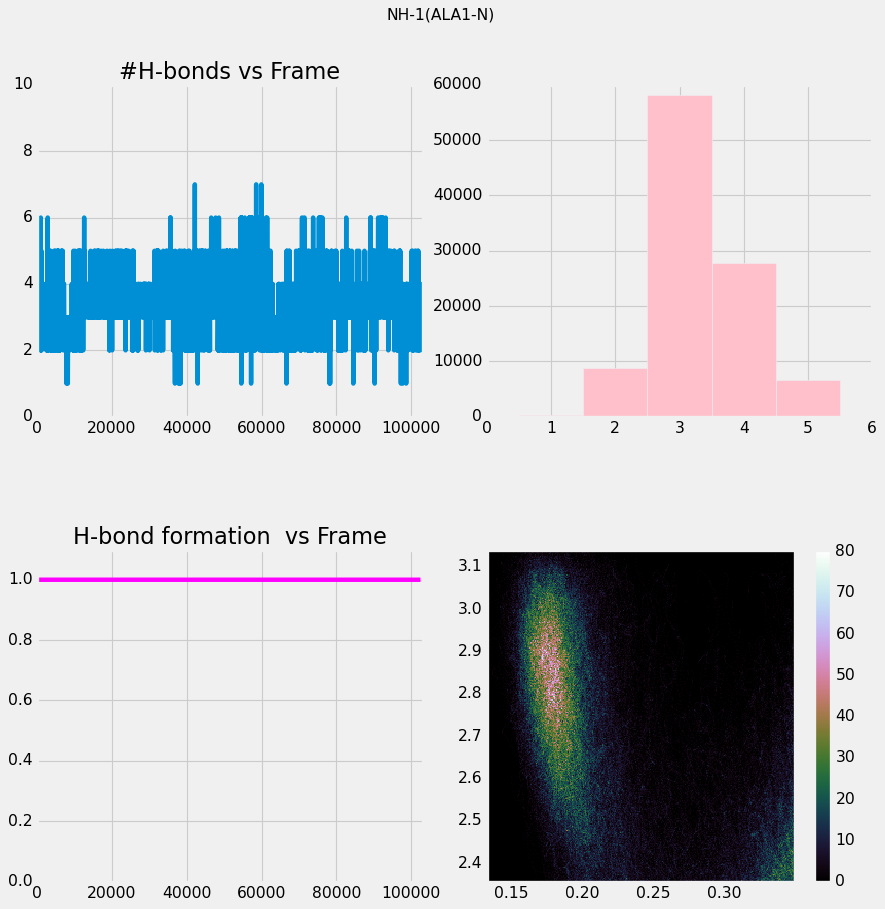

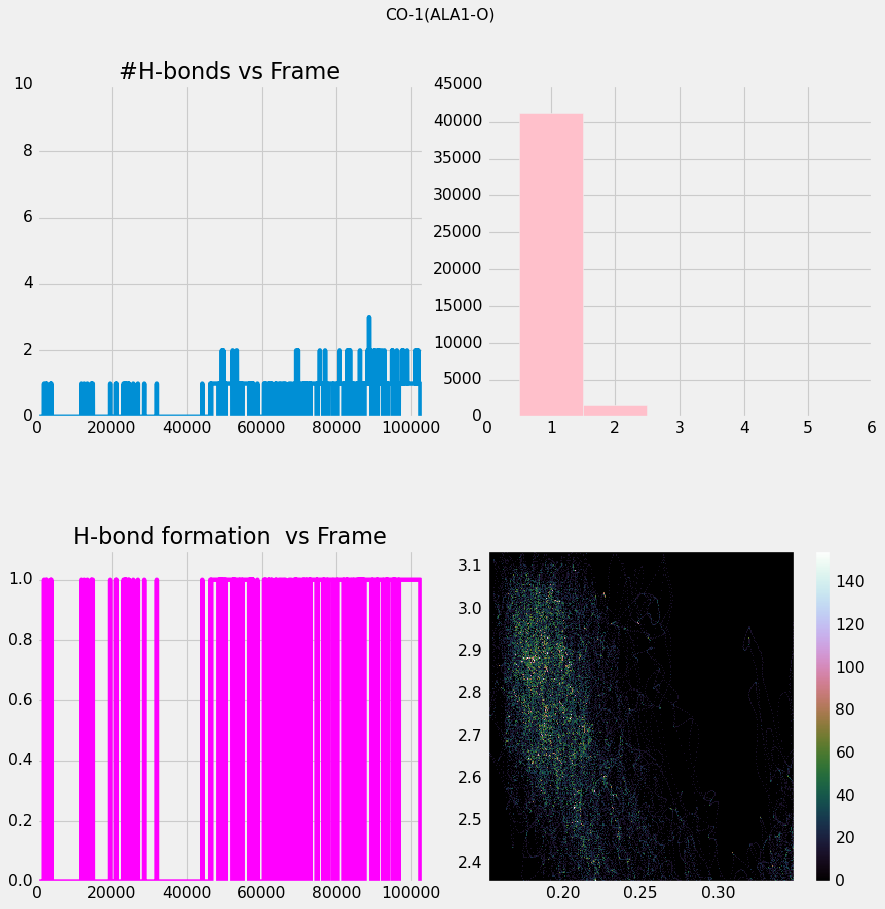

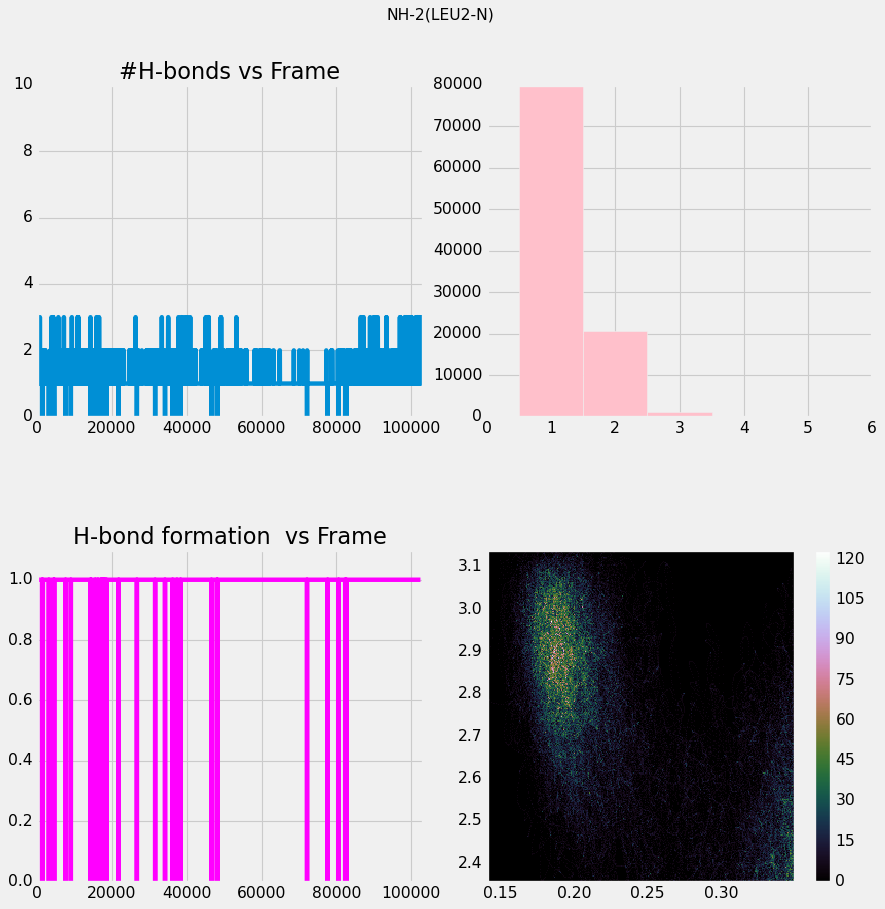

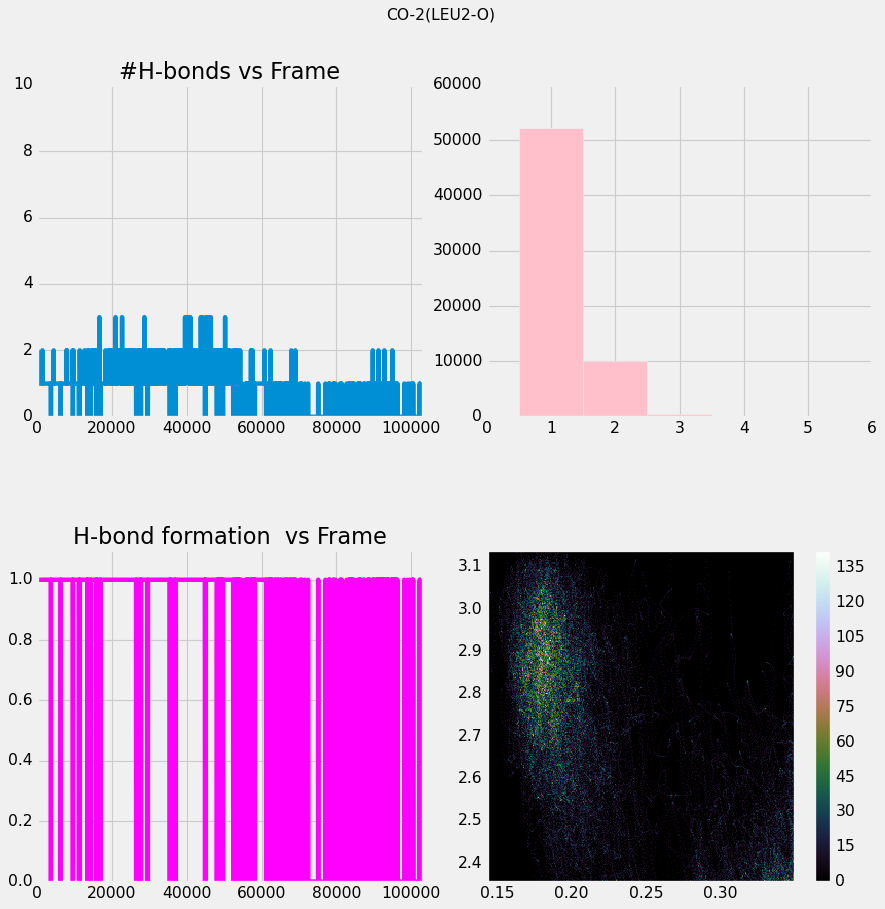

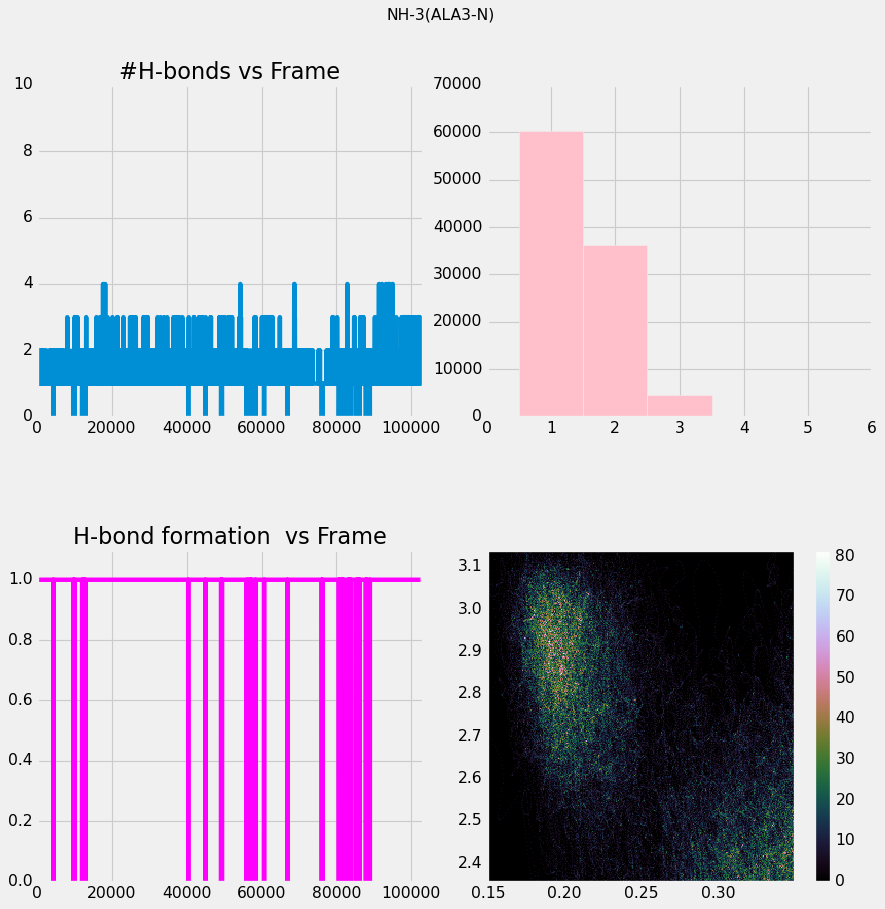

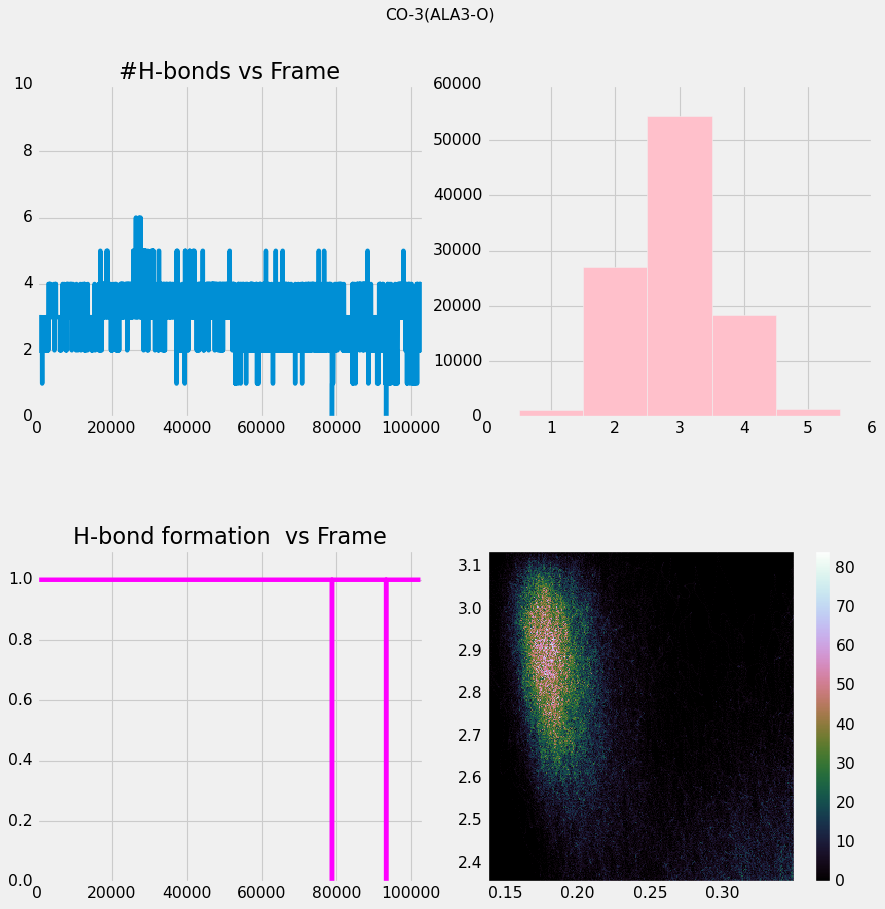

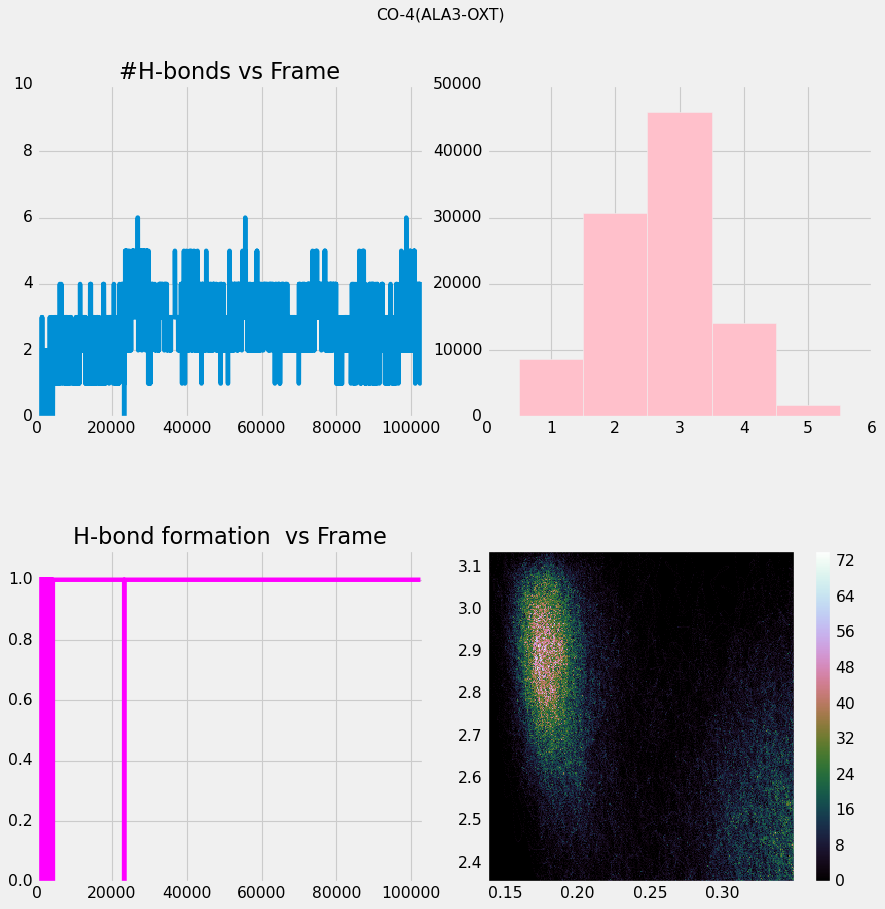

In [263]:
plt.style.use('fivethirtyeight' )
for i,idx in enumerate(polar_idx):
    

    fig=plt.figure(figsize=(12,12))
    grid=plt.GridSpec(2,4,hspace=0.4,wspace=0.4)

    gtr=fig.add_subplot(grid[0,:2],title='#H-bonds vs Frame')

    
    bgtr=fig.add_subplot(grid[1,:2],title='H-bond formation  vs Frame')

    histtr=fig.add_subplot(grid[0,2:])

    dis_ang_distr=fig.add_subplot(grid[1,2:])



    gtr.plot(group_track[i])

    gtr.set_ylim(0,10)

    gtr.set_xlim(0,103000)

    bgtr.plot(binary_group_track[i],color='magenta')

    bgtr.set_ylim(0,1.1)

    bgtr.set_xlim(0,103000)

    histtr.hist(group_track[i],color='pink',bins=np.arange(0.5,6.5,1))

    h,x,y,im=dis_ang_distr.hist2d(Distances[i],Angles[i],bins=300,density=True,cmap='cubehelix')

    plt.colorbar(im)
    fig.suptitle(x_axis[i])


In [71]:

possible_combs=[]
for comb in combs:
    if 'H' in group_names[str(new_ALA_wat.top.atom(comb[0]))]:
        possible_combs.append(comb)
len(possible_combs)

21

In [238]:
#Phase-3
water_bridges_distribution_2=[np.zeros(7) for comb in possible_combs]
frame_count=0
number_water_bridges=[[] for comb in possible_combs]
for frame in md.iterload('ALA_wat_traj.dcd',top='ALA_wat_trial.pdb',chunk=1,stride=1):
    frame_count=frame_count+1
    
    frame_H_BONDS=md.baker_hubbard(frame,exclude_water=False,distance_cutoff=0.35,angle_cutoff=135)
    H_BOND_1=[(bond[0],bond[1]) for bond in frame_H_BONDS]
    H_BOND_2=[(bond[1],bond[2]) for bond in frame_H_BONDS]
    all_bonds=set(H_BOND_2)|set(H_BOND_1)
    bond_graph=nx.DiGraph(list(all_bonds))
    bond_graph.add_nodes_from(polar_idx)
    for idx,comb in enumerate(possible_combs):
        path_found=False
        npath=0
        for path in nx.all_simple_paths(bond_graph,source=comb[0],target=comb[1],cutoff=14):#The length of all paths >=2(logic)
            path_found=path_found or True
            npath=npath+1
            
            l=len(path)-3  #if the path is indeed found it's minimum length is 1(Donor+Hydrogen + 2(H_2O)+Acceptor
                           #Here the length of interest is len(path)-3
            
            water_bridges_distribution_2[idx][l//2]=water_bridges_distribution_2[idx][l//2]+1
            
            
        if(not path_found):
            water_bridges_distribution_2[idx][0]=water_bridges_distribution_2[idx][0]+1
        
        number_water_bridges[idx].append(npath)
            

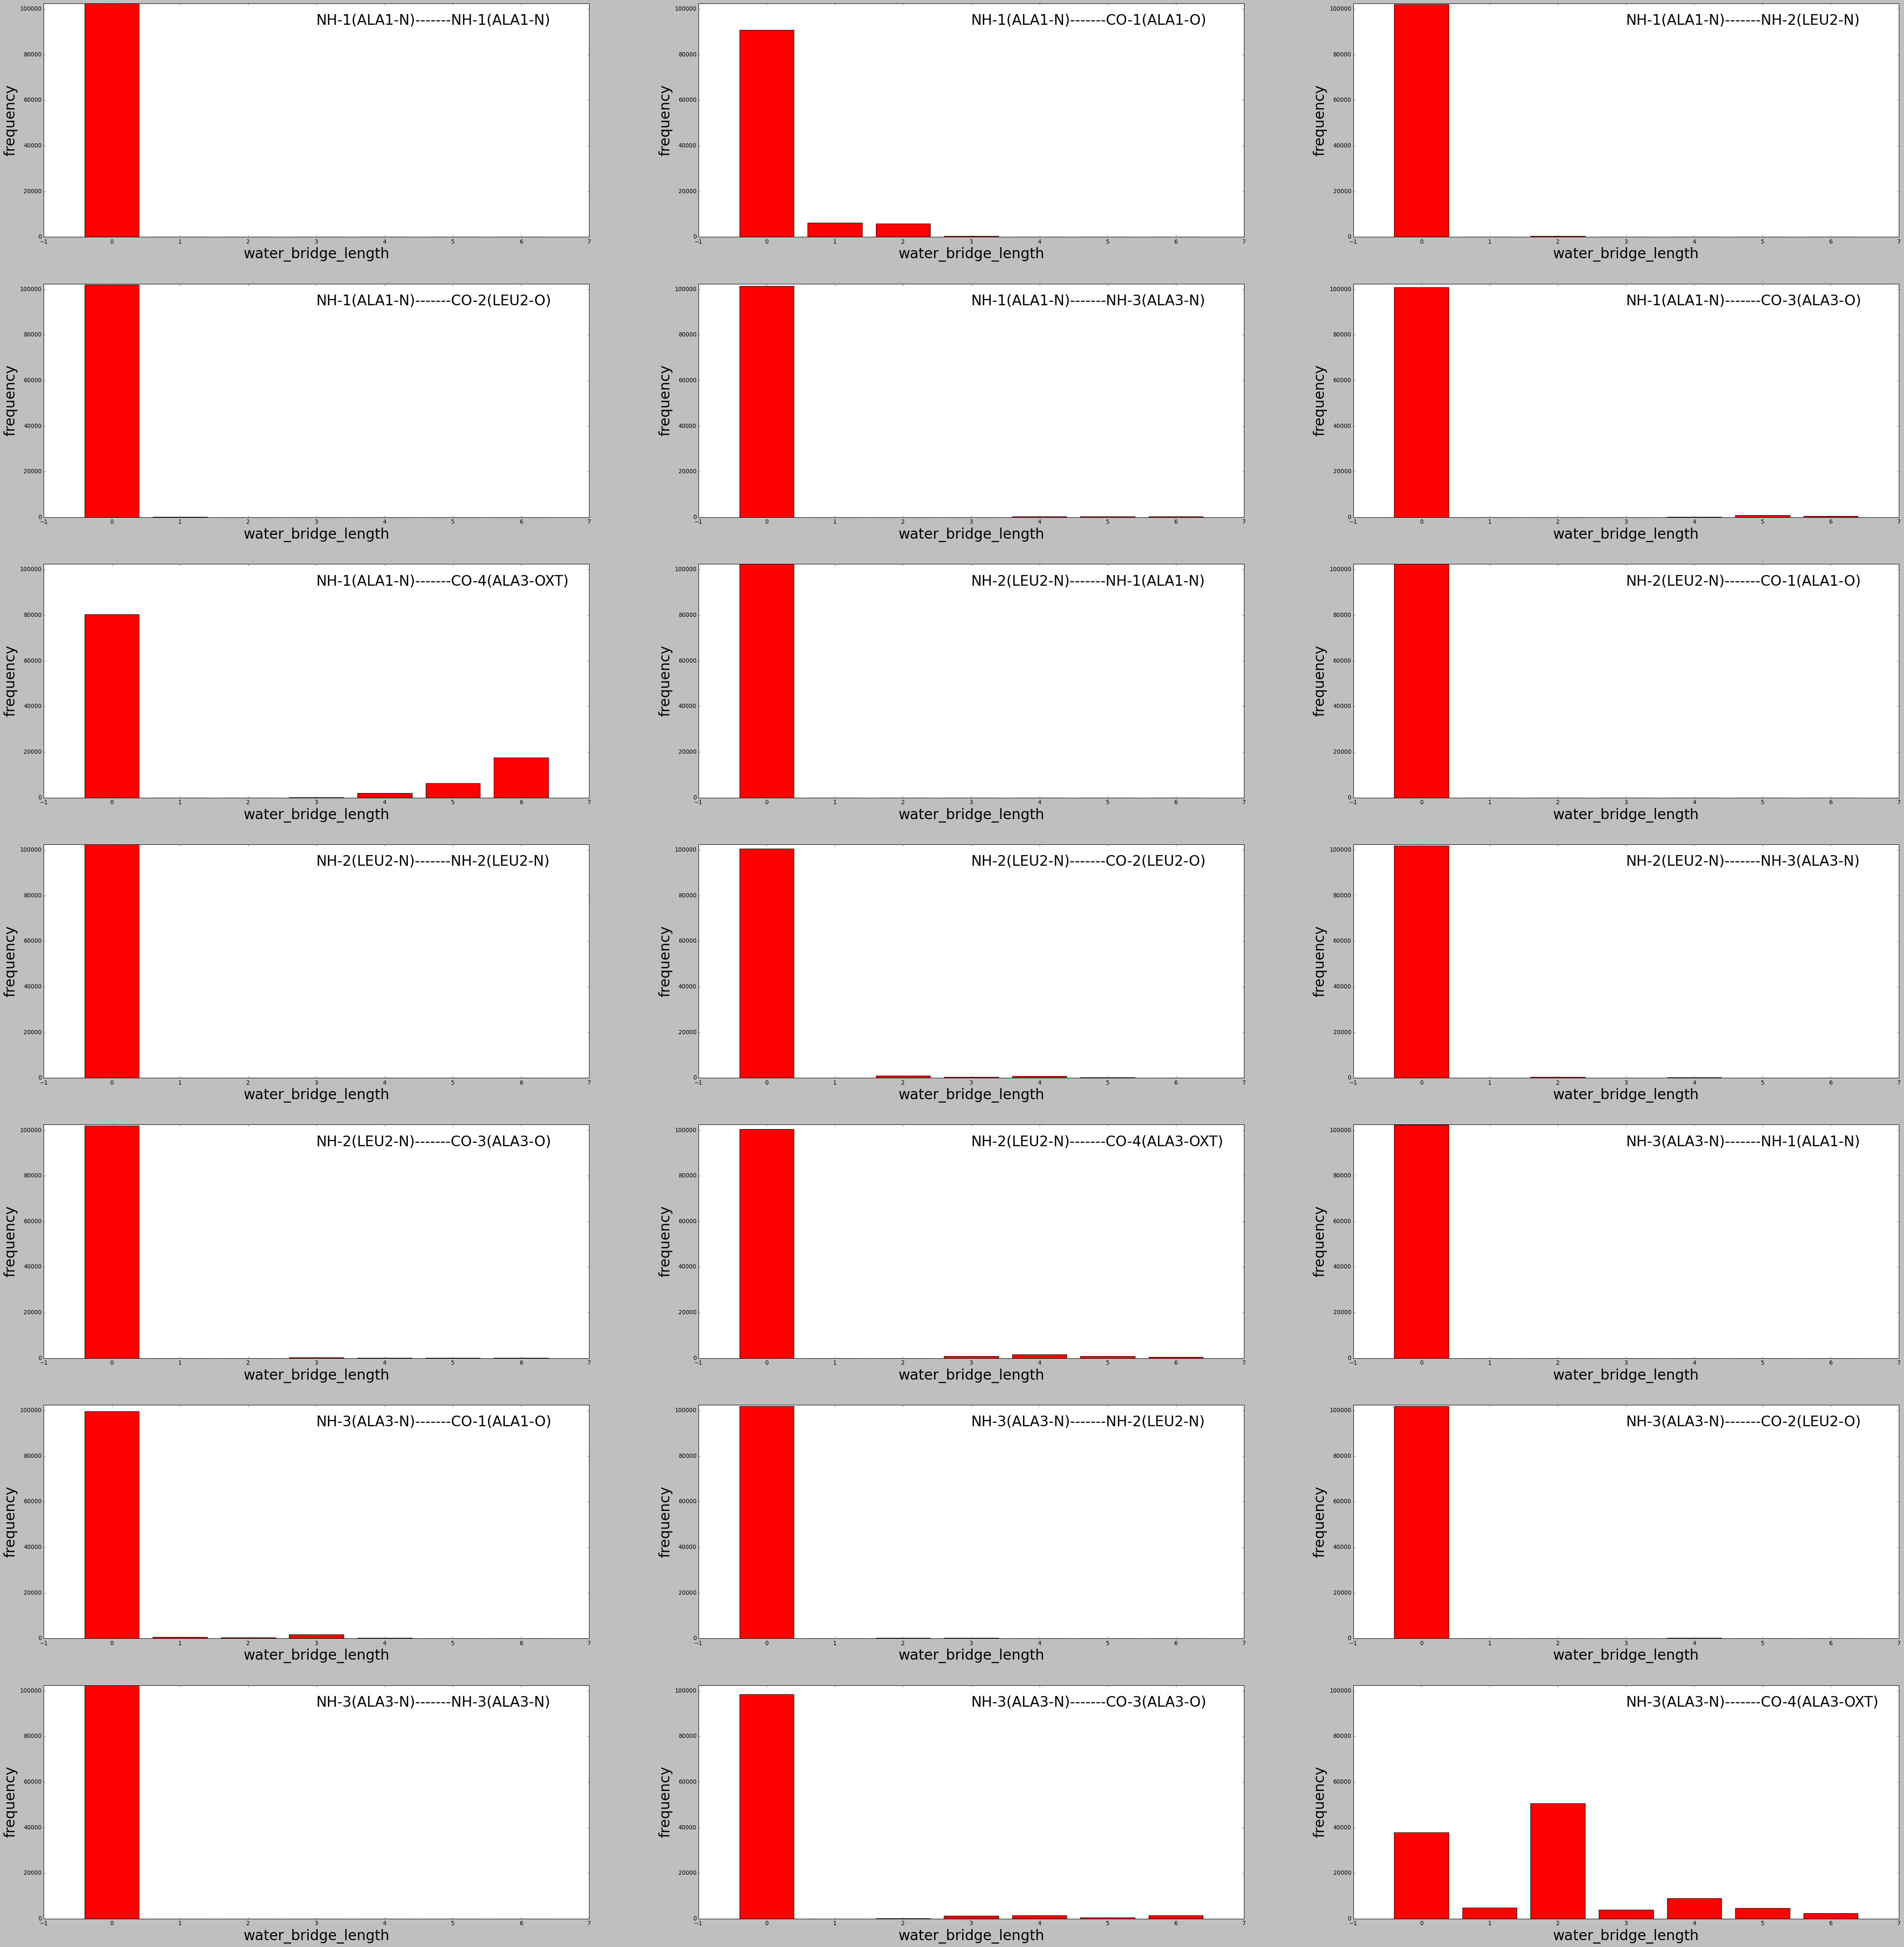

In [82]:
style=dict(size=30,color='black')
fig,ax=plt.subplots(7,3,figsize=(70,70))
for idx,comb in enumerate(possible_combs):
    ax[idx//3,idx%3].bar(np.arange(7),water_bridges_distribution_2[idx],color='red')
    ax[idx//3,idx%3].set_xlabel('water_bridge_length',**style)
    ax[idx//3,idx%3].set_ylabel('frequency',**style)
    ax[idx//3,idx%3].text(3,93000,group_names[str(new_ALA_wat[0].top.atom(comb[0]))]+"-------"+group_names[str(new_ALA_wat[0].top.atom(comb[1]))],**style)
    ax[idx//3,idx%3].set_ylim(0,102450)

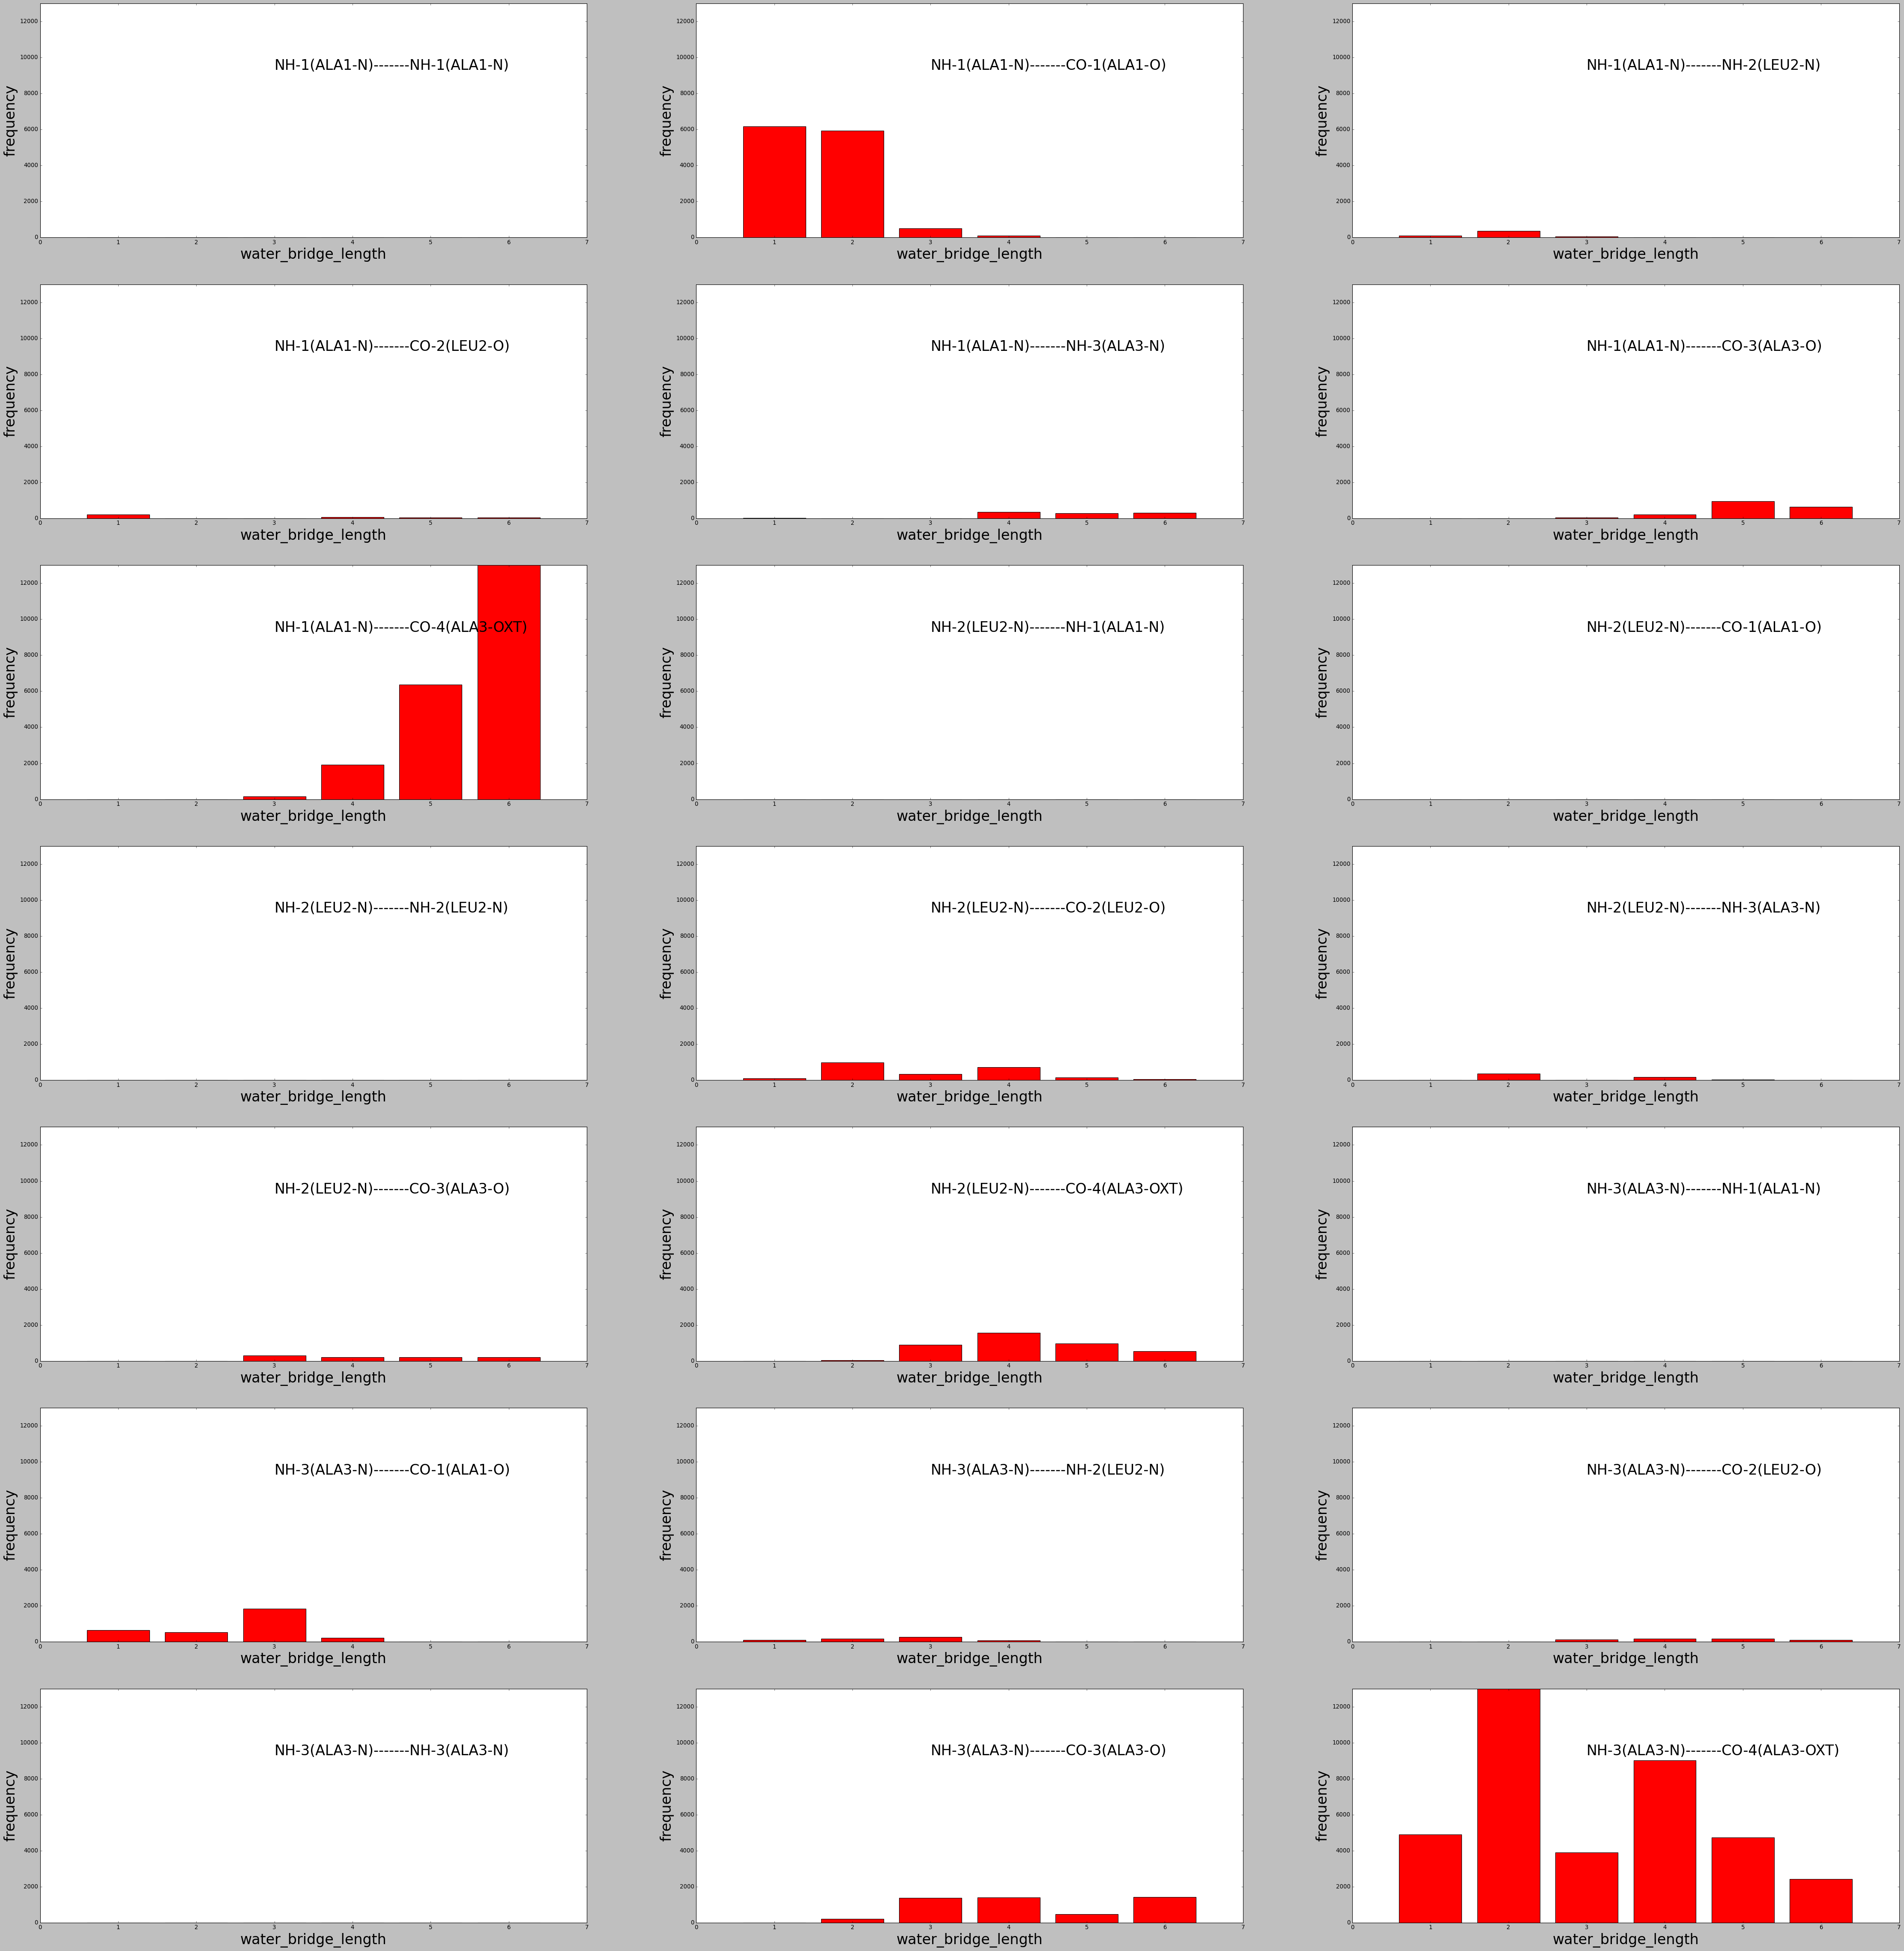

In [85]:
style=dict(size=30,color='black')
fig,ax=plt.subplots(7,3,figsize=(70,70))
for idx,comb in enumerate(possible_combs):
    ax[idx//3,idx%3].bar(np.arange(1,7),water_bridges_distribution_2[idx][1:],color='red')
    ax[idx//3,idx%3].set_xlabel('water_bridge_length',**style)
    ax[idx//3,idx%3].set_ylabel('frequency',**style)
    ax[idx//3,idx%3].text(3,9300,group_names[str(new_ALA_wat[0].top.atom(comb[0]))]+"-------"+group_names[str(new_ALA_wat[0].top.atom(comb[1]))],**style)
    ax[idx//3,idx%3].set_ylim(0,13000)

<ipython-input-269-c2c6515b66a8>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(12,12))


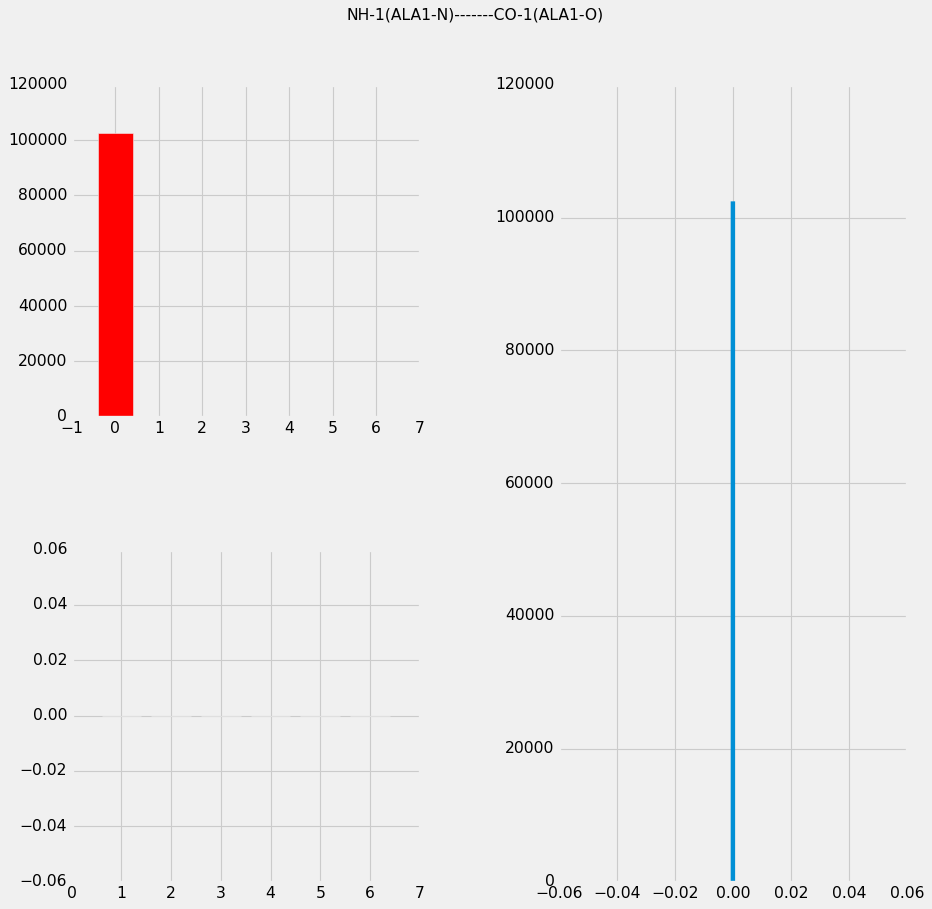

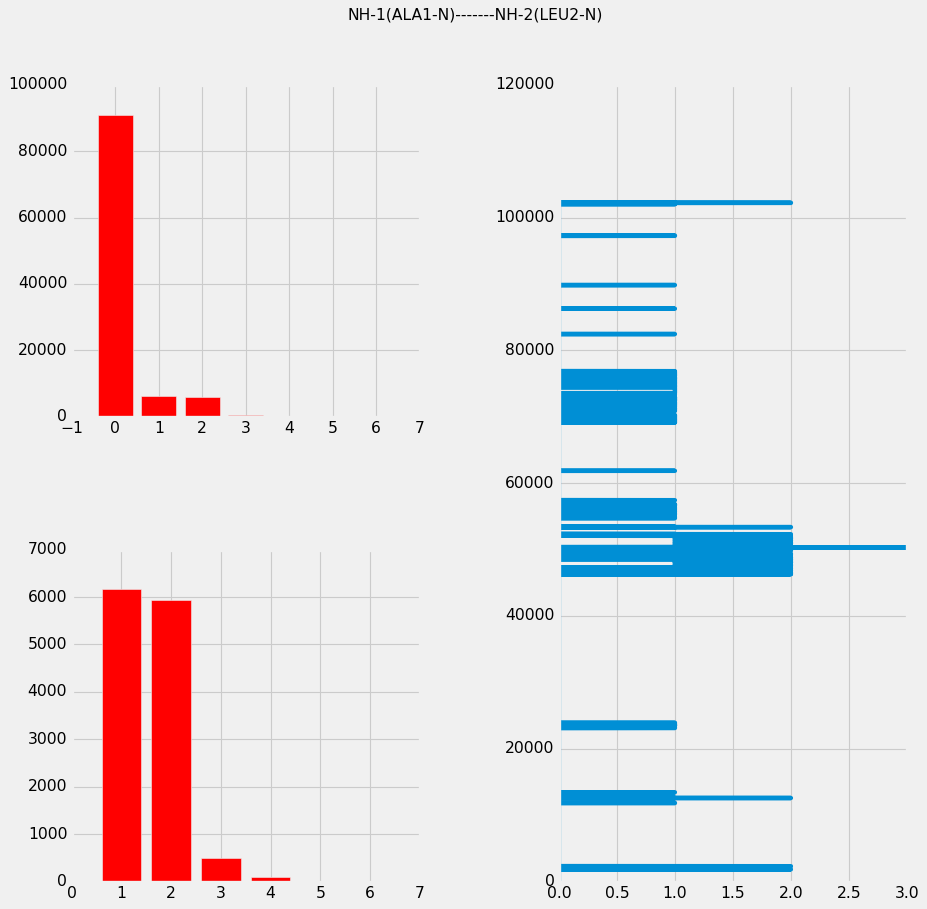

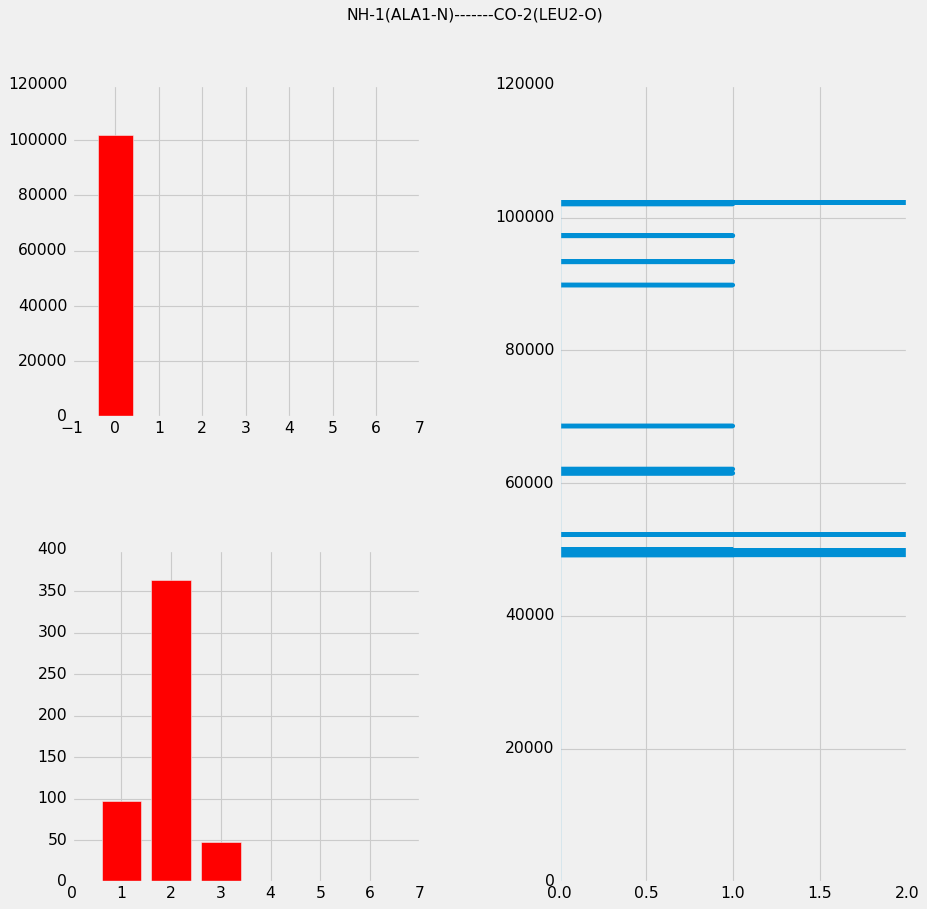

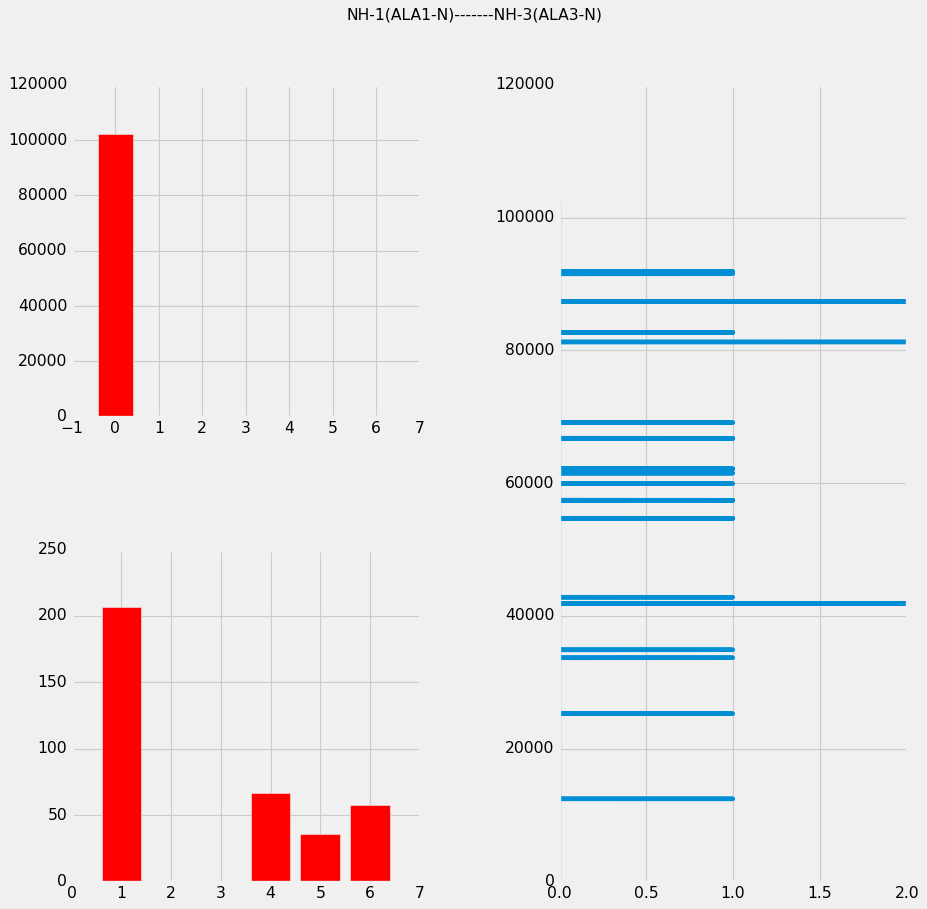

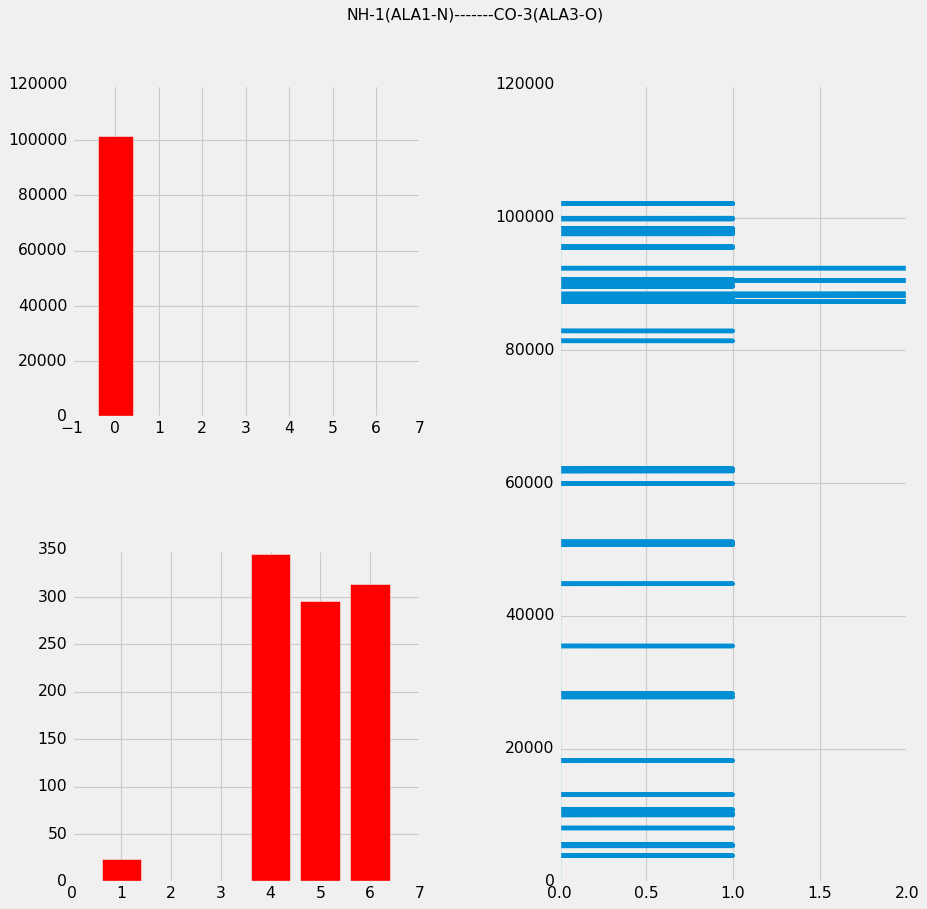

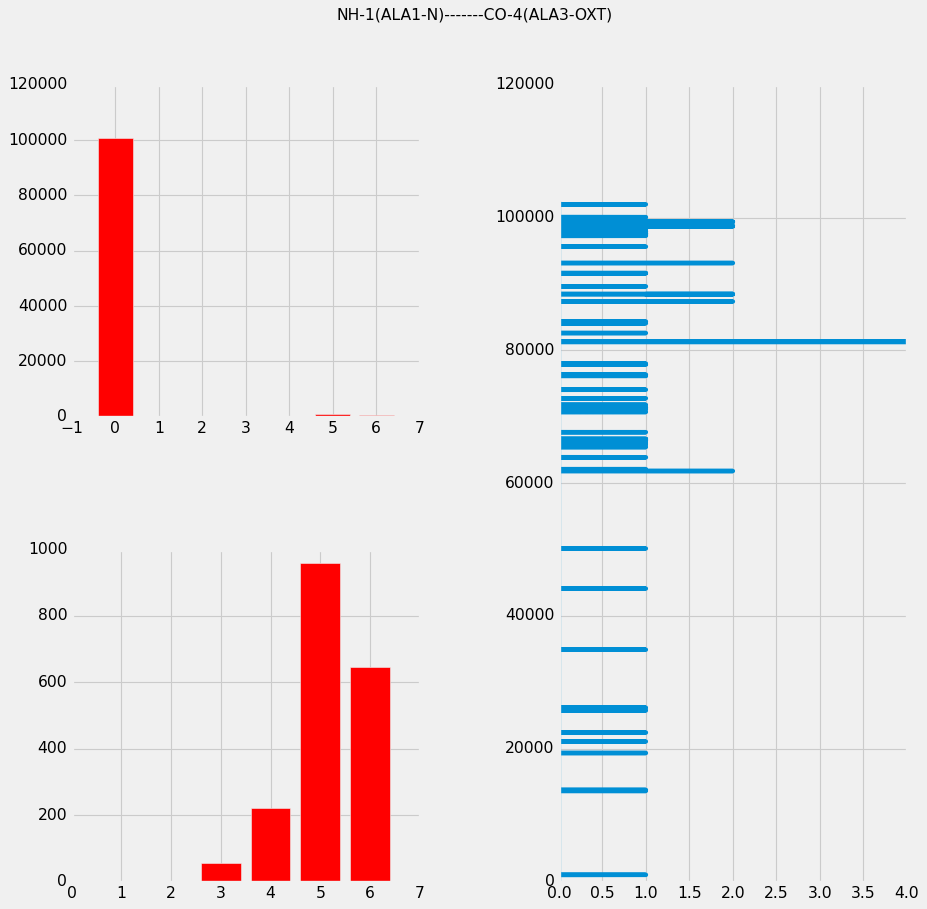

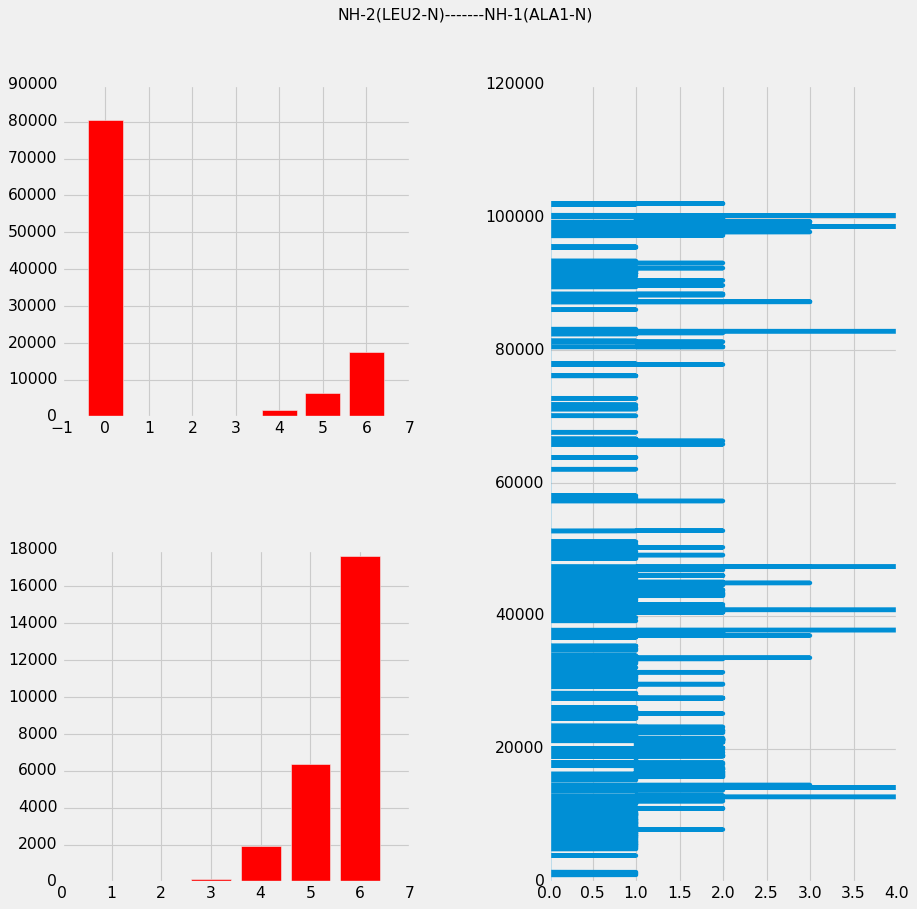

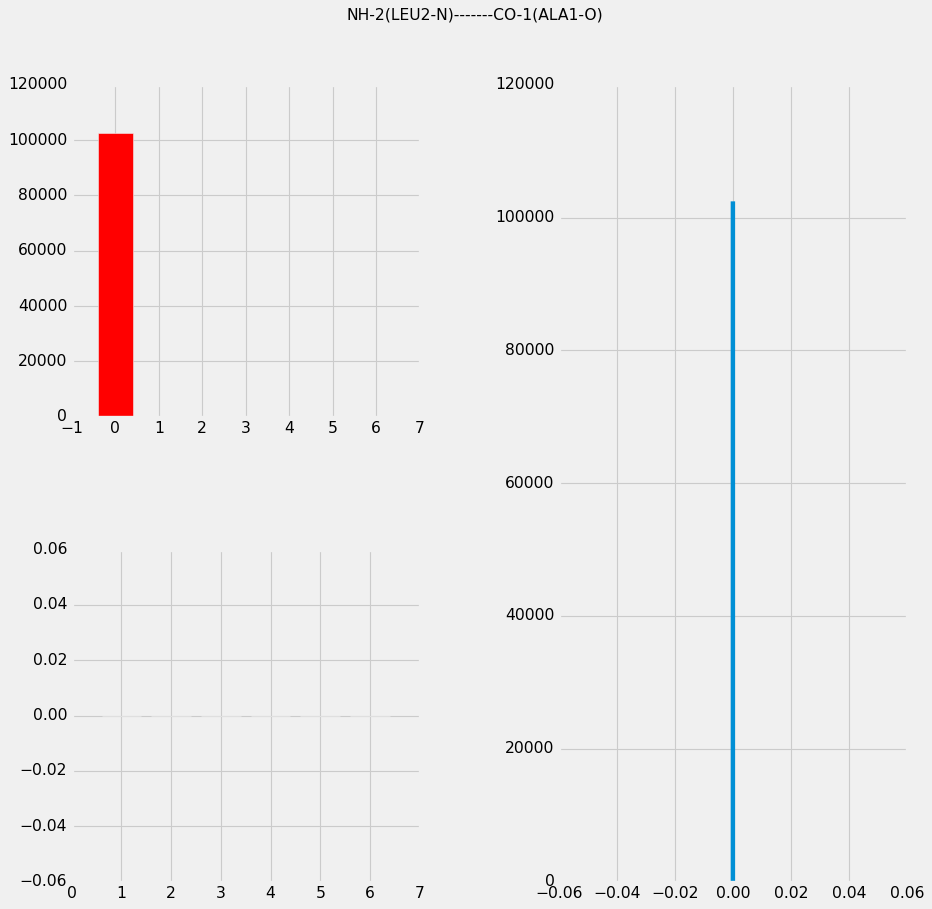

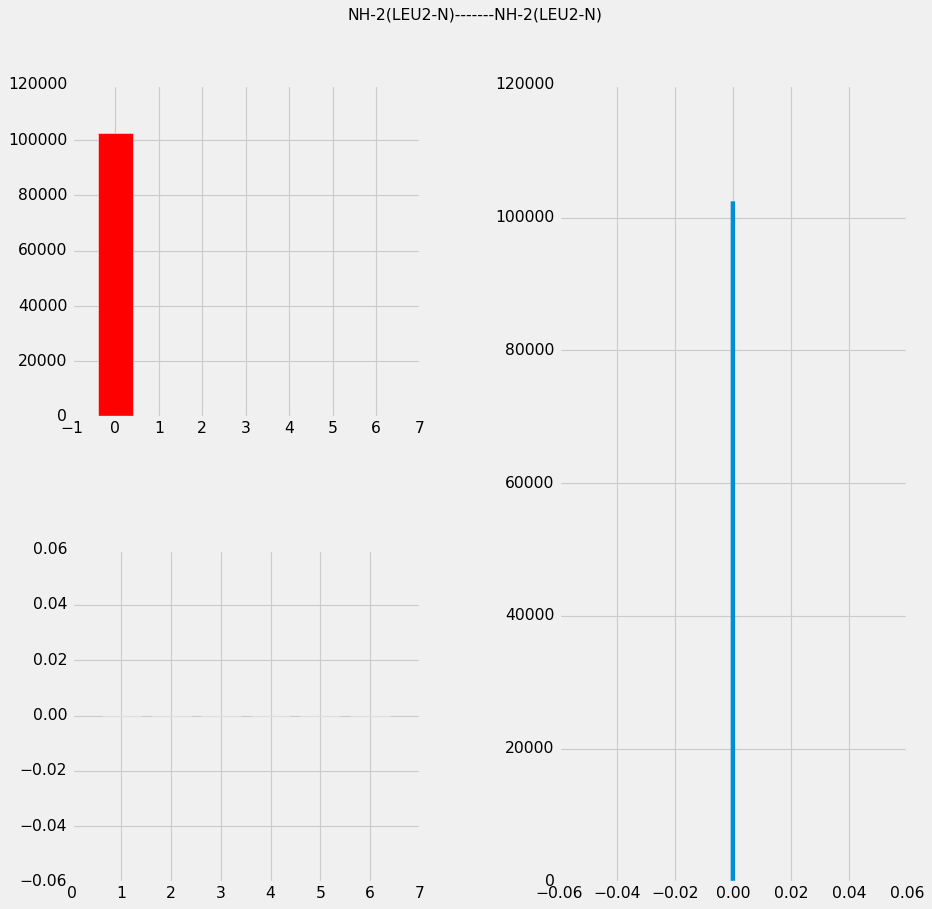

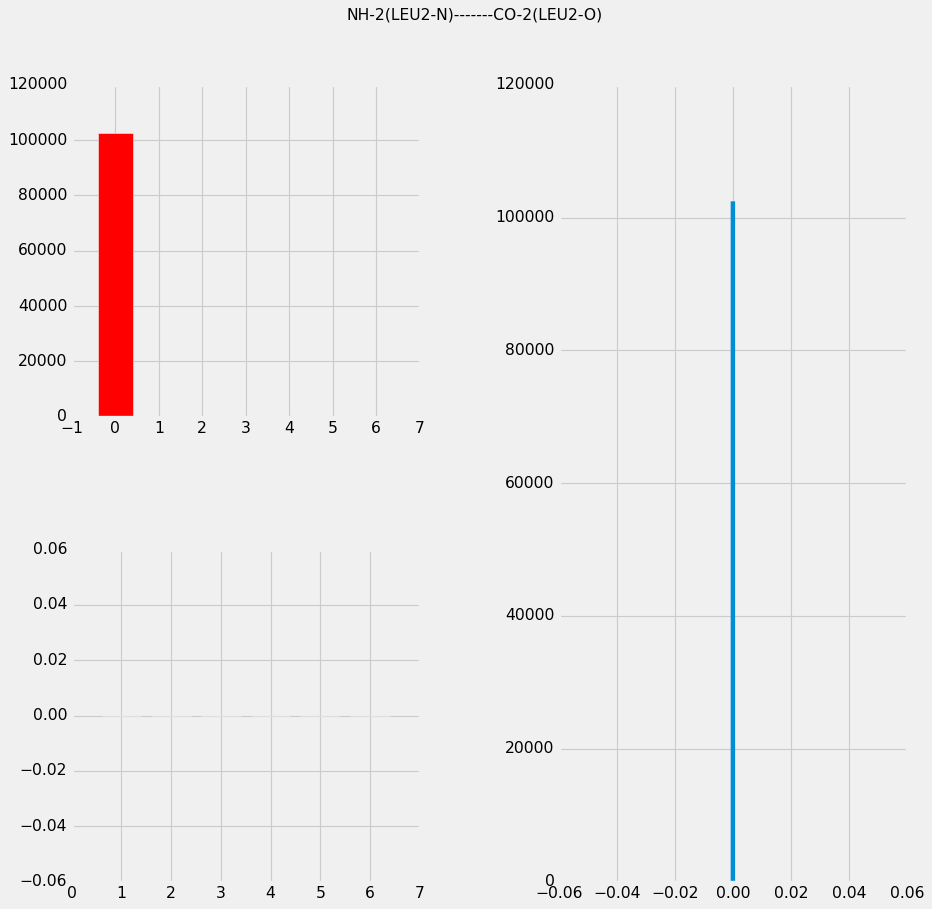

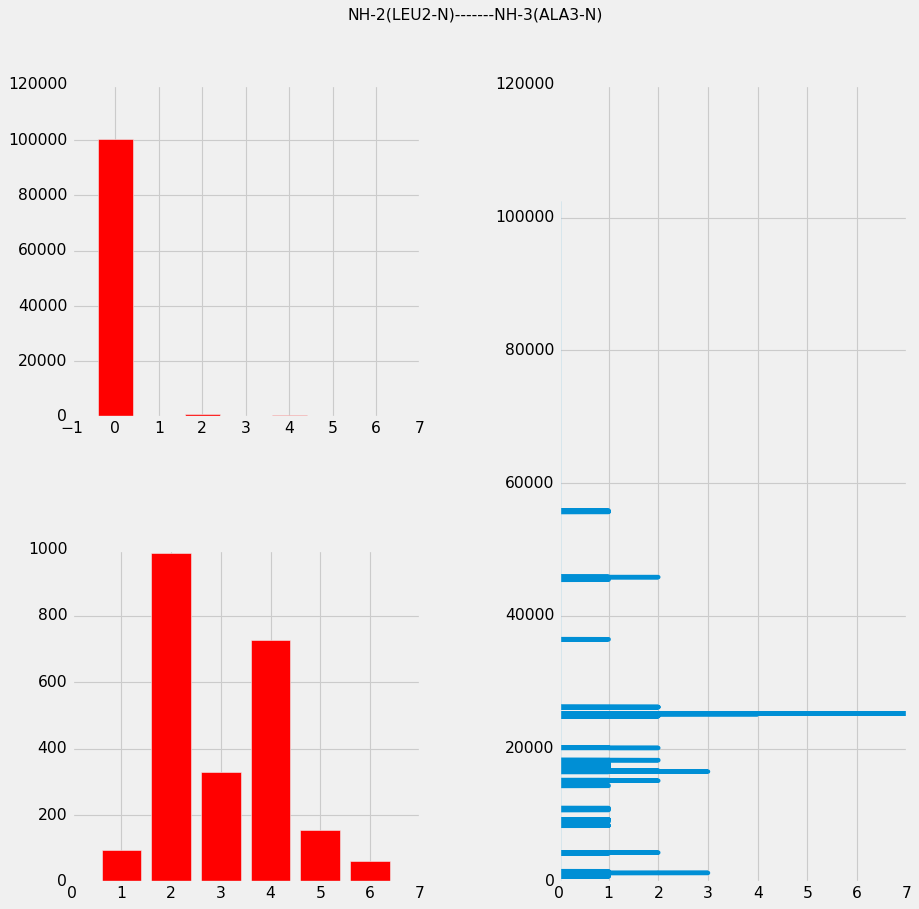

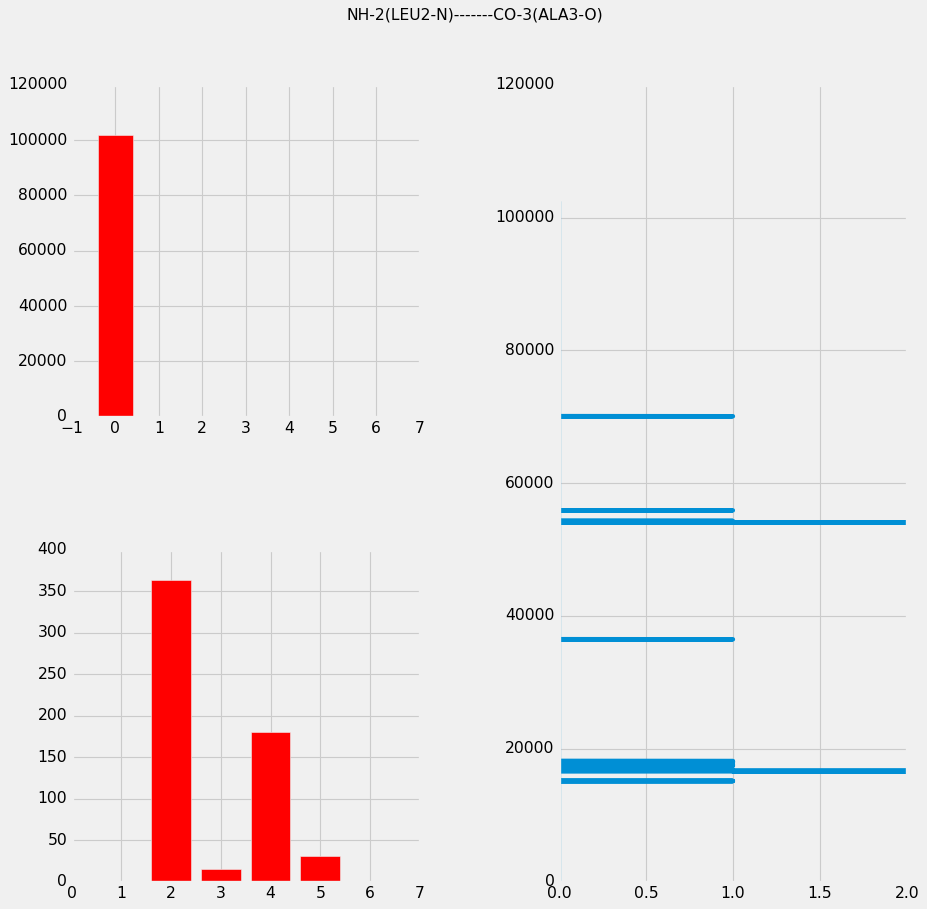

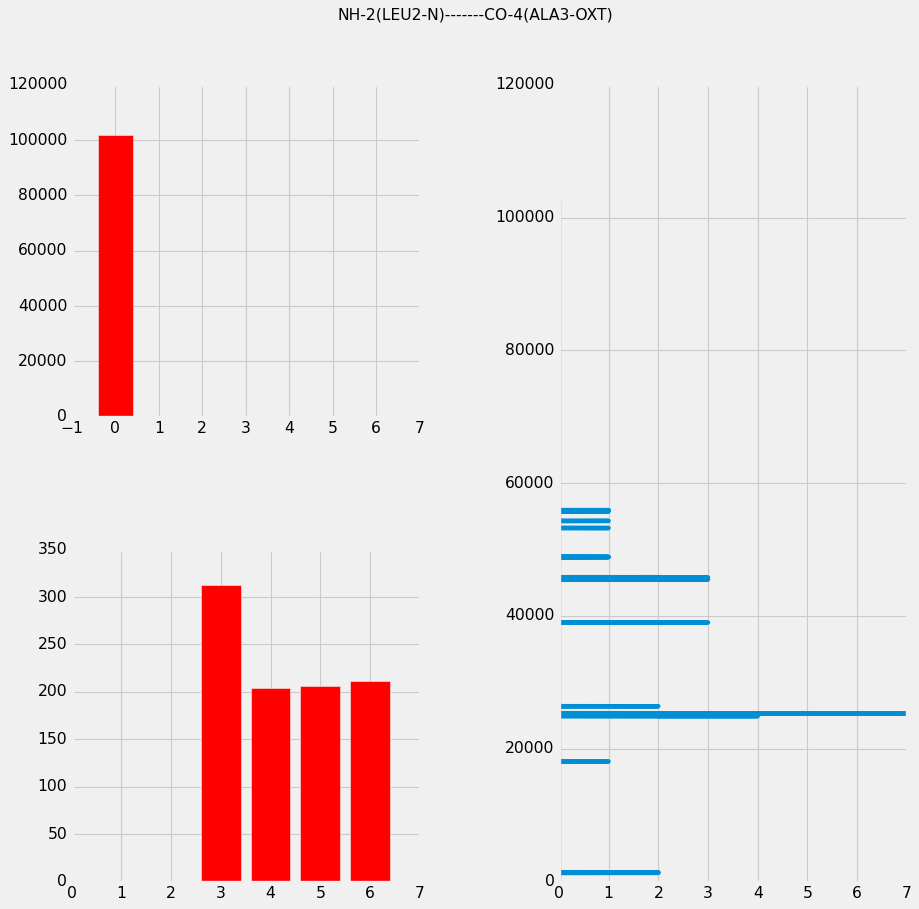

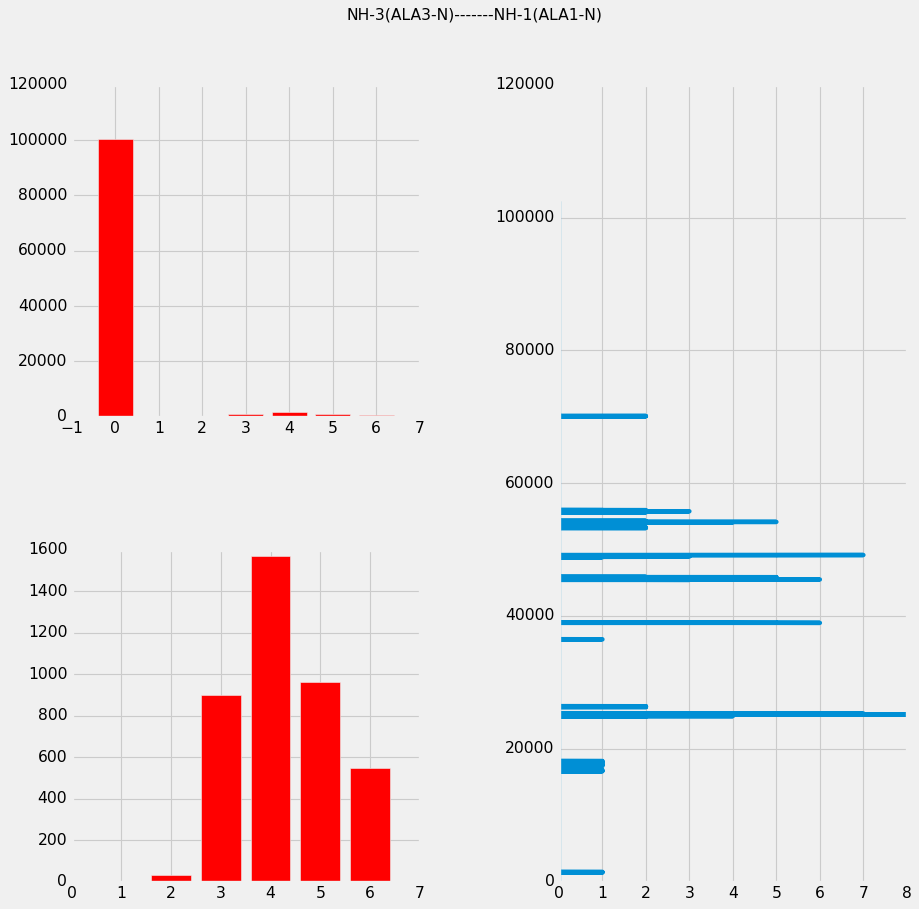

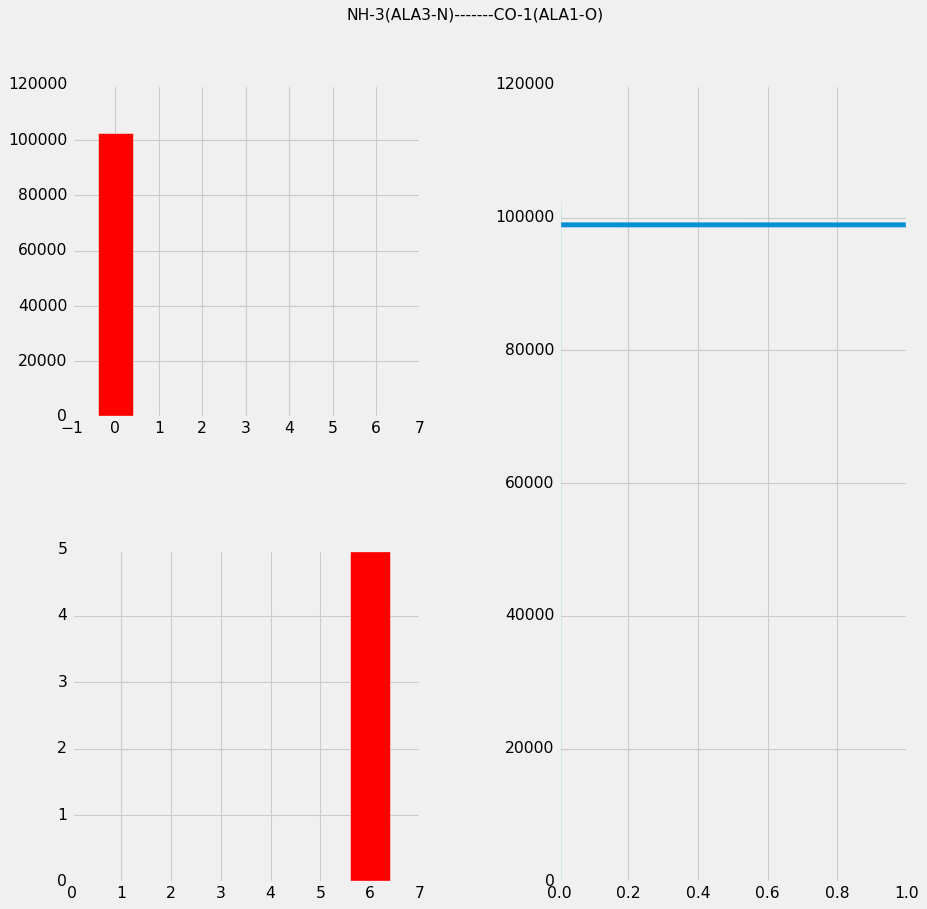

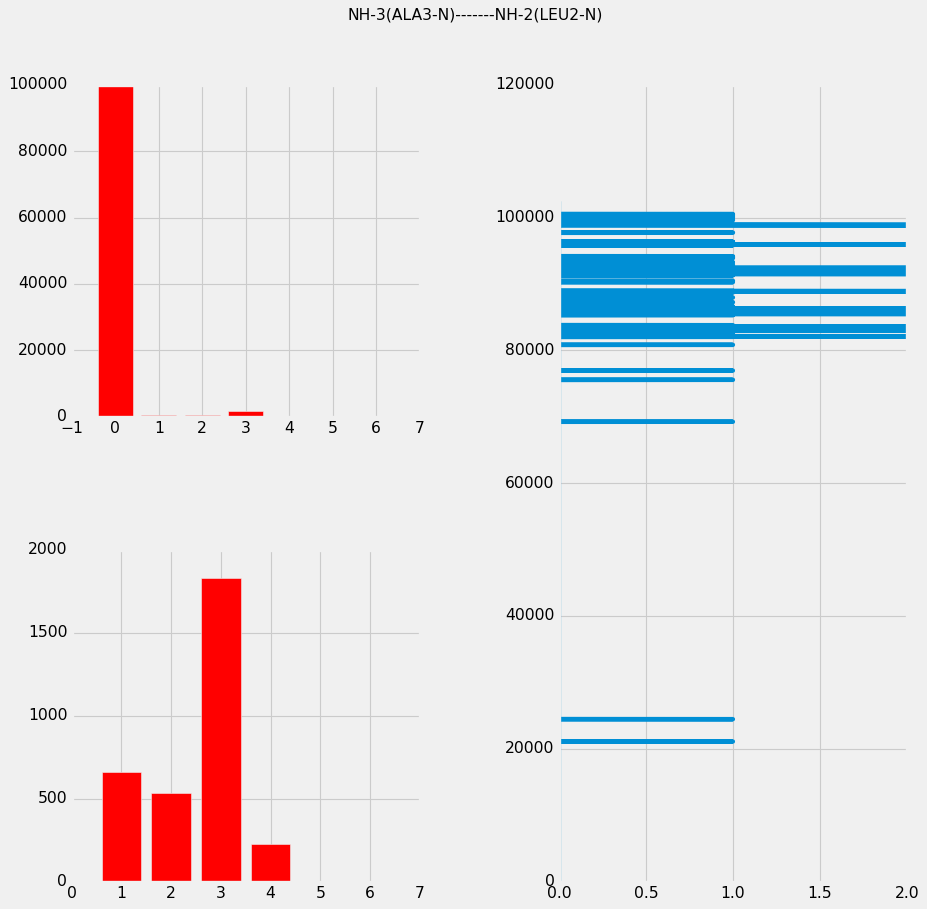

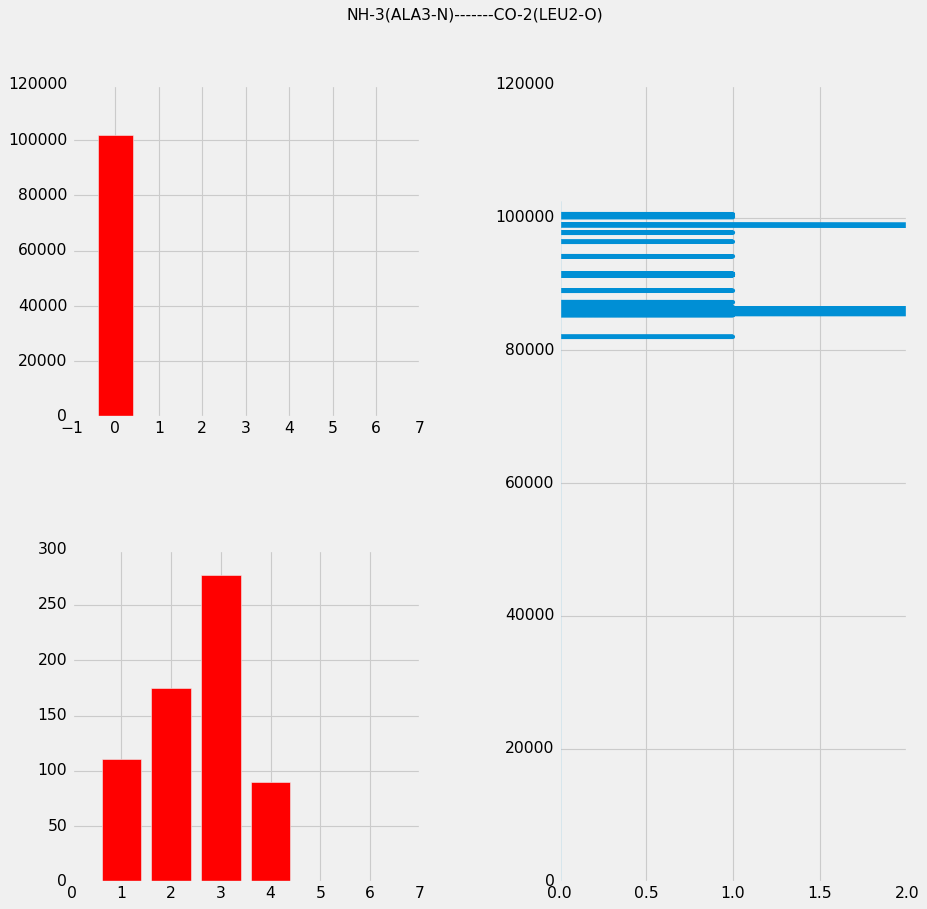

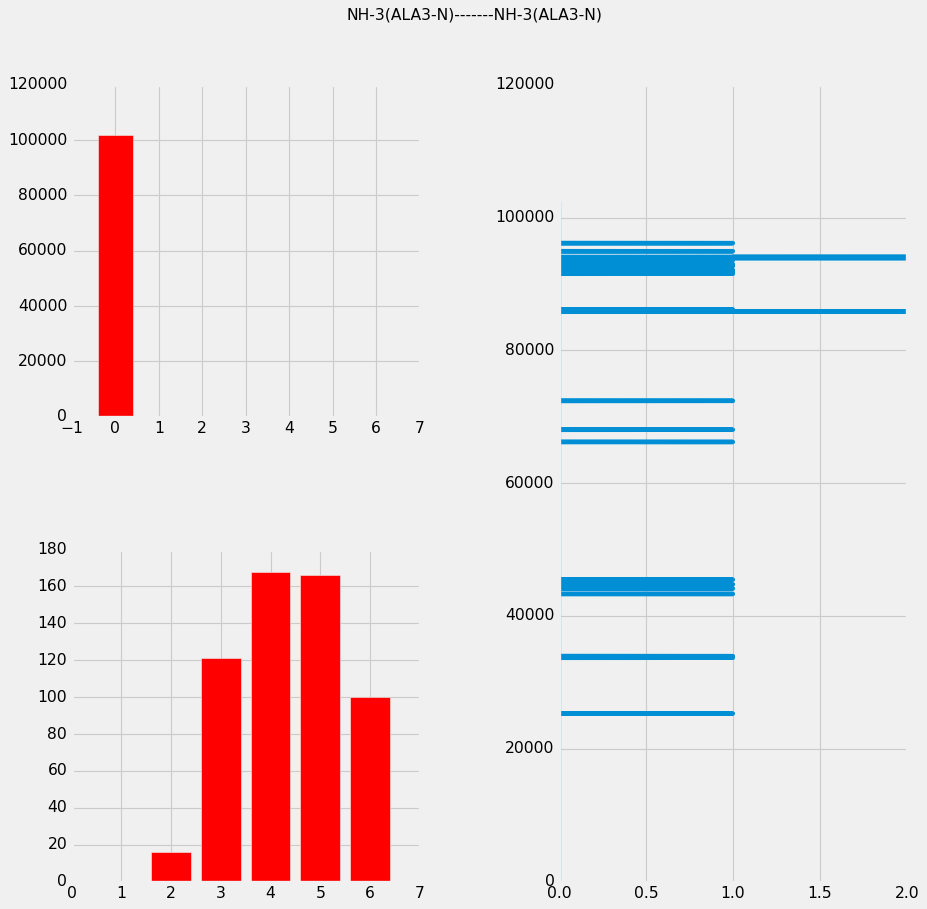

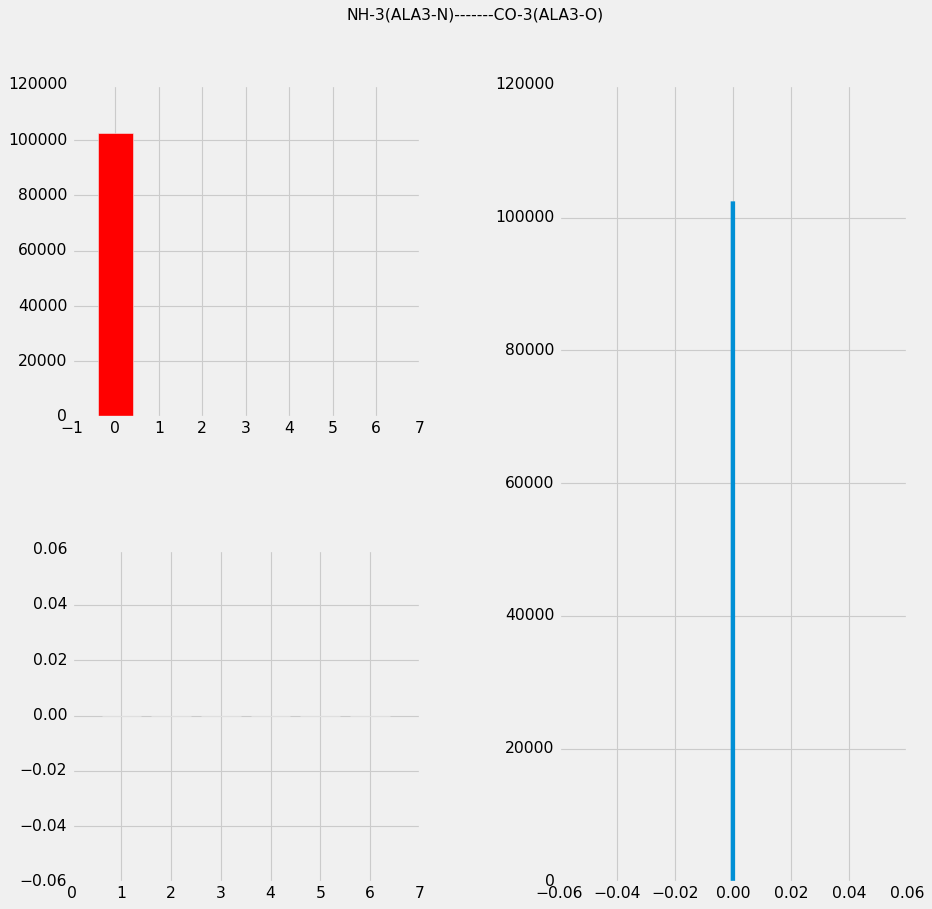

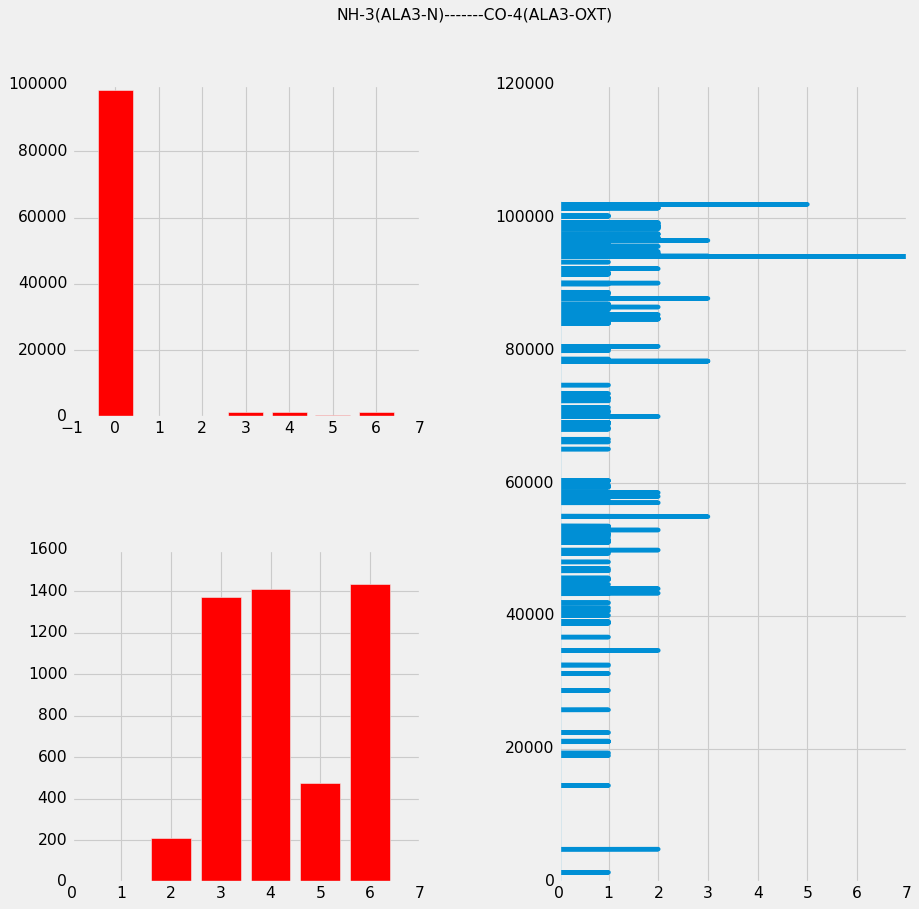

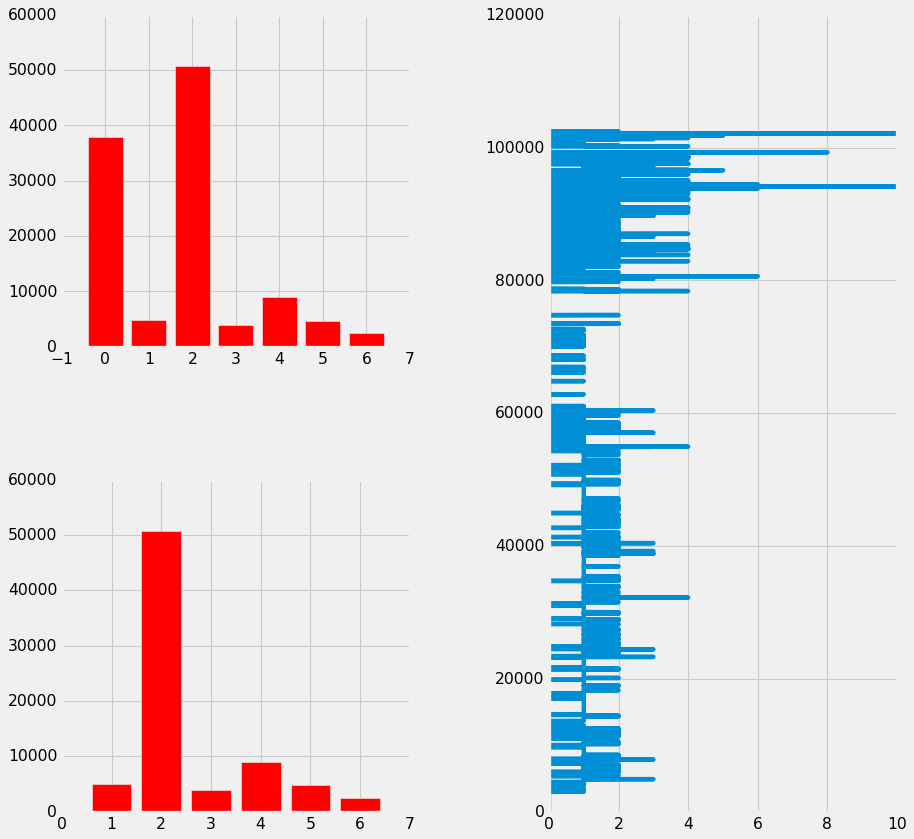

In [269]:
plt.style.use('fivethirtyeight')
for idx,comb in enumerate(possible_combs):
    fig.suptitle(group_names[str(new_ALA_wat[0].top.atom(comb[0]))]+"-------"+group_names[str(new_ALA_wat[0].top.atom(comb[1]))])
    fig=plt.figure(figsize=(12,12))
    grid=plt.GridSpec(2,2,hspace=0.4,wspace=0.4)
    wat_br_len=fig.add_subplot(grid[0,0])
    wat_br_len1=fig.add_subplot(grid[1,0])
    wat_bri_track=fig.add_subplot(grid[:,1]) 
    wat_br_len.bar(np.arange(7),water_bridges_distribution_2[idx],color='red')
    wat_br_len1.bar(np.arange(1,7),water_bridges_distribution_2[idx][1:],color='red')
    wat_bri_track.plot(number_water_bridges[idx],np.arange(102441))
